In [3]:
import numpy as np

def generator_regression(features, labels, batch_size, epoch_size, rebalance=False, rebalanced_thr=0):

    """

    Given the "features" array, this function  returns "batch_size" epochs of size "epoch_size" balanced or unbalanced.
    Batches can be equally sampled by two distributions defined by "rebalanced_thr" if "rebalance" is True.
    In the rebalance=True case returned batches are shuffled. Corresponding "labels" are returned in the same manner.

    params:
    features (np array) : data array in shape (time, num_channels),
    labels (np array) : in shape (time),
    batch_size (int) : number of samples per epoch, equivallent to keras model.fit batch_size,
    epoch_size (int) : time dimension of data vector defined as one training sample
                       dependent on the sampling frequency!,
    rebalance (boolean) : if True data is sampled evenly from the greater and smaller rebalanced_thr distributions,
    rebalanced_thr (float) : defines rebalancing thresholds for two distributions

    returns:
    batch_features (np array) : batch array in shape (batch_size, 1, num_channels, epoch_size),
    batch_labels (np array) : label array of size batch_size

    The batch_features shape is necessary for tensorflow train
    """
    chans = features.shape[1]
    batch_features = np.zeros([batch_size, 1, chans, epoch_size])  # definition of returned arrays
    batch_labels = np.zeros([batch_size])

    # the True statement is neccessary due to the "endless" model.fit iterations
    # it is hence terminated by the number of epoch being specified

    while True:
        for idx_label in np.arange(epoch_size, features.shape[0]-batch_size, batch_size):
            for i in range(batch_size):

                for ch in range(chans):
                    batch_features[i,0,ch,:] = features[(idx_label+i-epoch_size):i+idx_label,ch]
                batch_labels[i] = labels[idx_label+i]

            if rebalance == True:

                # resample balancing:
                # the indices of respective above and below threshold values are concatenated "num_pos" times
                # respectively the distribution with less samples is repeated
                # thus random sampling is avoided, but data samples are only concatenated

                dat_ = (batch_features, batch_labels)
                ind_below = np.where(batch_labels<=rebalanced_thr)[0]
                ind_above = np.where(batch_labels>rebalanced_thr)[0]

                # unformly sample from both distributions
                ind_sample_below = np.random.randint(0, ind_below.shape[0], size=int(batch_size/2))
                ind_sample_above = np.random.randint(0, ind_above.shape[0], size=int(batch_size/2))

                batch_features_ = np.concatenate((batch_features[ind_below[ind_sample_below],:,:,:], \
                                batch_features[ind_above[ind_sample_above],:,:,:]), axis=0)
                batch_labels_ = np.concatenate((batch_labels[ind_below[ind_sample_below]], \
                                batch_labels[ind_above[ind_sample_above]]), axis=0)
                yield batch_features_, batch_labels_
            else:
                yield batch_features, batch_labels


In [1]:
import IO
import os
import numpy as np
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from collections import OrderedDict
from scipy import signal, stats

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
import tensorflow.keras as keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
K.set_image_data_format('channels_first') # IMPORTANT, otherwise eegnet wont work with input shape!

from scipy.stats import spearmanr

import label_generator

# free GPU memory, since it won't clear itself in one sess.
from numba import cuda 
#device = cuda.get_current_device()
#device.reset()

# BIDS path
subjects = ['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']
#PATH = "C:\\Users\\ICN_admin\\Charité - Universitätsmedizin Berlin\\Interventional Cognitive Neuromodulation - Data\\Datasets\\BIDS Pittsburgh\\"
PATH = r"C:\Users\icn_admin\OneDrive - Charité - Universitätsmedizin Berlin\Data\Datasets\BIDS Pittsburgh"
vhdr_files = IO.get_all_vhdr_files(PATH)



# custom definition of cost fct.
def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def get_data_raw_combined(sub, sess, loc ,f_):
    
    start = 0
    for f in f_:
        dat, chs = IO.read_BIDS_file(os.path.join(PATH, f))
        if loc == "ECOG":
            idx__ = [idx for idx, ch in enumerate(chs) if ch.startswith("E") or ch.startswith("M")]
        else:
            if len([idx for idx, ch in enumerate(chs) if ch.startswith("S")]) == 0:
                continue
            idx__ = [idx for idx, ch in enumerate(chs) if ch.startswith("S") or ch.startswith("M")]
        if start == 0:
            start = 1
            dat_ = dat[idx__,:]
            chs_ = chs # chs might change in other runs 
        else:
            if dat[idx__].shape[0] == dat_.shape[0]:
                dat_ = np.concatenate((dat_, dat[idx__,:]), axis=1)
    if chs[-2] == "MOV_RIGHT_CLEAN":
        if sess == "right":
            y_ips = dat_[-2,:]
        elif sess == "left":
            y_con = dat_[-2,:]
    if chs[-2] == "MOV_LEFT_CLEAN":
        if sess == "right":
            y_con = dat_[-2,:]
        elif sess == "left":
            y_ips = dat_[-2,:]
    if chs[-1] == "MOV_RIGHT_CLEAN":
        if sess == "right":
            y_ips = dat_[-1,:]
        elif sess == "left":
            y_con = dat_[-1,:]
    if chs[-1] == "MOV_LEFT_CLEAN":
        if sess == "right":
            y_con = dat_[-1,:]
        elif sess == "left":
            y_ips = dat_[-1,:]
    return dat_[:-4, :], y_con, y_ips

         
def get_label_from_gen(gen_, X_, batch_size):
    """
    well this function is necessary to get the respective training and validation labels which 
        had been provided by the generator
    """
    for i in range(int(X_.shape[0]/batch_size)):
        if i == 0:
            arr = np.array(next(gen_)[1])
        else:
            arr = np.concatenate((arr, next(gen_)[1]), axis=0)
    return arr

def correlation__(x, y):    
    mx = tf.math.reduce_mean(x)
    my = tf.math.reduce_mean(y)
    xm, ym = x-mx, y-my
    r_num = tf.math.reduce_mean(tf.multiply(xm,ym))        
    r_den = tf.math.reduce_std(xm) * tf.math.reduce_std(ym)
    return  r_num / r_den

In [2]:
cv = KFold(n_splits=3, shuffle=False)
kernLength = 64 # half of fs
batch_size = 4000
fs_new = 128
samples = 128
fs = 1000
ONLY_GET_DATA = True

In [4]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

### Test EEGNet based on 1. Raw Data 2. fs=128Hz (default implementation) 3. 

In [5]:
print(vhdr_files)

['C:\\Users\\icn_admin\\OneDrive - Charité - Universitätsmedizin Berlin\\Data\\Datasets\\BIDS Pittsburgh\\sub-000\\ses-right\\ieeg\\sub-000_ses-right_task-force_run-0_ieeg.vhdr', 'C:\\Users\\icn_admin\\OneDrive - Charité - Universitätsmedizin Berlin\\Data\\Datasets\\BIDS Pittsburgh\\sub-000\\ses-right\\ieeg\\sub-000_ses-right_task-force_run-1_ieeg.vhdr', 'C:\\Users\\icn_admin\\OneDrive - Charité - Universitätsmedizin Berlin\\Data\\Datasets\\BIDS Pittsburgh\\sub-000\\ses-right\\ieeg\\sub-000_ses-right_task-force_run-2_ieeg.vhdr', 'C:\\Users\\icn_admin\\OneDrive - Charité - Universitätsmedizin Berlin\\Data\\Datasets\\BIDS Pittsburgh\\sub-000\\ses-right\\ieeg\\sub-000_ses-right_task-force_run-3_ieeg.vhdr', 'C:\\Users\\icn_admin\\OneDrive - Charité - Universitätsmedizin Berlin\\Data\\Datasets\\BIDS Pittsburgh\\sub-001\\ses-left\\ieeg\\sub-001_ses-left_task-force_run-0_ieeg.vhdr', 'C:\\Users\\icn_admin\\OneDrive - Charité - Universitätsmedizin Berlin\\Data\\Datasets\\BIDS Pittsburgh\\sub-00

In [6]:
for sub in subjects:
    for loc in ["ECOG", "STN"]:
        for sess in ["right", "left"]:
            f_ = [file for file in vhdr_files if sub in file and sess in file]
            if len(f_) == 0:
                continue
            
            X, y_con, y_ips = get_data_raw_combined(sub, sess, loc, f_)  # Raw Data 
            
            # resample data to fs_new
            y_con = signal.resample(y_con, int(y_con.shape[0]*fs_new / fs), axis=0)
            y_ips = signal.resample(y_ips, int(y_ips.shape[0]*fs_new / fs), axis=0)
            X = signal.resample(X, int(X.shape[1]*fs_new / fs), axis=1).T
            X_here = X
            
            Yp_tr= OrderedDict() # Y_predict_train
            sc_tr= OrderedDict() # score_train
            Yp_te= OrderedDict()
            sc_te= OrderedDict()
            Yt_tr= OrderedDict()
            Yt_te= OrderedDict()
            hist_ = OrderedDict()
            
            for lat in ["CON", "IPS"]:
                if lat == "CON": 
                    y_ = y_con
                else:
                    y_ = y_ips
                    
                print("RUNNING subject "+str(sub)+" sess: "+str(sess)+" lat: "+ str(lat)+ "loc: "+str(loc))
                score_te = []; score_tr = []
                pr_te = []; te = []; pr_tr = []; tr = []
                for train_index, test_index in cv.split(X):
                    X_train, X_test=X_here[train_index, :], X_here[test_index, :]
                    y_train, y_test=y_[train_index], y_[test_index]

                    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.7,shuffle=False)

                    #model  = DeepConvNet(Chans = chans, Samples = samples)
                    chans = X_train.shape[1]
                    if ONLY_GET_DATA is True:
                        continue
                    model  = EEGNet(Chans = chans, Samples = samples, kernLength=kernLength)
                    model.compile(loss = "mae", optimizer = keras.optimizers.Adam(),\
                                  metrics=[correlation__])

                    es = EarlyStopping(monitor='val_correlation__', mode='max', verbose=1, patience=10)
                    mc = ModelCheckpoint('best_model.h5', monitor='val_correlation__', mode='max', verbose=1, save_best_only=True)
                    gen_tr = label_generator.generator_regression(X_test, y_test, batch_size, \
                                            samples, rebalance=True, rebalanced_thr=0.1)
                    gen_val = label_generator.generator_regression(X_val, y_val, batch_size, \
                                            samples, rebalance=True, rebalanced_thr=0.1)
                    with tf.device('/gpu:0'): 
                        hist = model.fit(gen_tr, validation_data=gen_val, steps_per_epoch=int(X_train.shape[0]/batch_size), \
                                         epochs=100, validation_steps=int(X_val.shape[0]/batch_size), callbacks=[es,mc])
                    model = load_model('best_model.h5', custom_objects={'correlation__': correlation__})
                    
                    # get the training set label and predictions with rebalance = False
                    gen_ = label_generator.generator_regression(X_train, y_train, batch_size, \
                                                                samples, rebalance=False, rebalanced_thr=0.1)
                    with tf.device('/gpu:0'): 
                        pr_train = model.predict(gen_, steps=int(X_train.shape[0]/batch_size))[:,0]
                    gen_ = label_generator.generator_regression(X_train, y_train, batch_size, \
                                            samples, rebalance=False, rebalanced_thr=0.1)
                    y_train_ = get_label_from_gen(gen_, X_train, batch_size)
                    
                    # get the test set label and predictions
                    gen_ = label_generator.generator_regression(X_test, y_test, batch_size, \
                                            samples, rebalance=False, rebalanced_thr=0.1)
                    with tf.device('/gpu:0'): 
                        pr_test = model.predict(gen_, steps=int(X_test.shape[0]/batch_size))[:,0]
                    gen_ = label_generator.generator_regression(X_test, y_test, batch_size, \
                                            samples, rebalance=False, rebalanced_thr=0.1)
                    y_test_ = get_label_from_gen(gen_, X_test, batch_size)

                    pr_tr.append(pr_train)
                    tr.append(y_train_)
                    pr_te.append(pr_test)
                    te.append(y_test_)
                    
                    sc = metrics.r2_score(pr_test, y_test_)
                    if sc < 0: sc = 0
                    print(sc)
                    print("score test: "+str(sc))
                    score_te.append(sc)
                    
                    sc = metrics.r2_score(pr_train, y_train_)
                    if sc < 0: sc = 0
                    print("score train: "+str(sc))
                    score_tr.append(sc)
                    
                    pr_tr.append(pr_train)
                    tr.append(y_train_)
                    pr_te.append(pr_test)
                    te.append(y_test_)
                    
                Yp_te[lat] = pr_te
                Yp_tr[lat] = pr_tr
                Yt_te[lat] = te
                Yt_tr[lat] = tr
                sc_te[lat] = np.mean(score_te)
                sc_tr[lat] = np.mean(score_tr)
                hist_[lat] = hist.history

            predict_ = {
                "y_pred_test": Yp_te,
                "y_test": Yt_te,
                "y_pred_train": Yp_tr,
                "y_train": Yt_tr,
                "score_tr": sc_tr,
                "score_te": sc_te,
                "hist": hist_
            }

            np.save(sub + "BestChpredictions_"+str(loc)+"-ses-"+str(sess)+".npy", predict_)
            

Extracting parameters from C:\Users\icn_admin\OneDrive - Charité - Universitätsmedizin Berlin\Data\Datasets\BIDS Pittsburgh\sub-000\ses-right\ieeg\sub-000_ses-right_task-force_run-0_ieeg.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\icn_admin\OneDrive - Charité - Universitätsmedizin Berlin\Data\Datasets\BIDS Pittsburgh\sub-000\ses-right\ieeg\sub-000_ses-right_task-force_run-1_ieeg.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\icn_admin\OneDrive - Charité - Universitätsmedizin Berlin\Data\Datasets\BIDS Pittsburgh\sub-000\ses-right\ieeg\sub-000_ses-right_task-force_run-2_ieeg.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\icn_admin\OneDrive - Charité - Universitätsmedizin Berlin\Data\Datasets\BIDS Pittsburgh\sub-000\ses-right\ieeg\sub-000_ses-right_task-force_run-3_ieeg.vhdr...
Setting channel info structure...
RUNNING subject 000 sess: right lat: CONloc: ECOG


C:\code\Anaconda3\envs\tf2\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\code\Anaconda3\envs\tf2\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\code\Anaconda3\envs\tf2\lib\site-packages\IPython\core\interactiveshell.py", line 2878, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-b76d8fe1596c>", line 95, in <module>
    hist_[lat] = hist.history
NameError: name 'hist' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\code\Anaconda3\envs\tf2\lib\site-packages\IPython\core\interactiveshell.py", line 1823, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\code\Anaconda3\envs\tf2\lib\site-packages\IPython\core\ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "C:\code\Anaconda3\envs\tf2\lib\site-packages

NameError: name 'hist' is not defined

### given this dataset (patient 000), train 1. with balancing generator

In [6]:
device = cuda.get_current_device()

In [7]:
device

<weakproxy at 0x000001B82BC33F98 to Device at 0x000001B82BAFCD88>

In [7]:
# the GPU is full and needs to be emptied first: 
device = cuda.get_current_device()
device.reset()

In [8]:
np.sum(np.array(y_train>0.1))/y_train.shape[0]

0.08275953098532679

In [9]:
np.sum(np.array(y_test>0.1))/y_test.shape[0]

0.08380301210385291

In [10]:
np.sum(np.array(y_val>0.1))/y_val.shape[0]

0.05312596242685556

In [11]:
chans

6

In [59]:
# well looks like the data is highly imbalanced

In [12]:
kernLength

64

In [13]:
samples

128

In [14]:
chans = 6

In [24]:
model  = EEGNet(Chans = chans, Samples = samples, kernLength=kernLength)
model.compile(loss = "mae", optimizer = keras.optimizers.Adam(),\
              metrics=[correlation__])

es = EarlyStopping(monitor='val_correlation__', mode='max', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_correlation__', mode='max', verbose=1, save_best_only=True)

In [25]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 6, 128)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 6, 128)         512       
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 6, 128)         32        
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 16, 1, 128)        96        
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 1, 128)        64        
_________________________________________________________________
activation (Activation)      (None, 16, 1, 128)        0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 16, 1, 32)        

In [15]:
device = cuda.get_current_device()

In [16]:
device

<weakproxy at 0x000001B82BC33F98 to Device at 0x000001B82BAFCD88>

In [17]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [29]:
REBALANCE_THR = 0.1

gen_tr = generator_regression(X_train, y_train, batch_size, \
                    samples, rebalance=True, rebalanced_thr=REBALANCE_THR)
gen_val = generator_regression(X_val, y_val, batch_size, \
                    samples, rebalance=True, rebalanced_thr=REBALANCE_THR)
with tf.device('/gpu:0'):
    hist = model.fit(gen_tr, validation_data=gen_val, steps_per_epoch=int(X_train.shape[0]/batch_size), \
                     epochs=100, validation_steps=int(X_val.shape[0]/batch_size), callbacks=[es,mc])
model = load_model('best_model.h5', custom_objects={'correlation__': correlation__})

# get the training set label and predictions with rebalance = False
gen_ = generator_regression(X_train, y_train, batch_size, \
                                            samples, rebalance=False, rebalanced_thr=0.1)
pr_train = model.predict(gen_, steps=int(X_train.shape[0]/batch_size))[:,0]
gen_ = generator_regression(X_train, y_train, batch_size, \
                        samples, rebalance=False)
y_train_ = get_label_from_gen(gen_, X_train, batch_size)

# get the test set label and predictions
gen_ = generator_regression(X_test, y_test, batch_size, \
                        samples, rebalance=False)
pr_test = model.predict(gen_, steps=int(X_test.shape[0]/batch_size))[:,0]
gen_ = generator_regression(X_test, y_test, batch_size, \
                        samples, rebalance=False)
y_test_ = get_label_from_gen(gen_, X_test, batch_size)

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing 

Epoch 18/100
11/11 [==============================] - ETA: 0s - loss: 0.1710 - correlation__: 0.8135
Epoch 00018: val_correlation__ improved from 0.85447 to 0.87213, saving model to best_model.h5
11/11 [==============================] - 2s 181ms/step - loss: 0.1710 - correlation__: 0.8135 - val_loss: 0.2336 - val_correlation__: 0.8721
Epoch 19/100
11/11 [==============================] - ETA: 0s - loss: 0.1700 - correlation__: 0.8148
Epoch 00019: val_correlation__ did not improve from 0.87213
11/11 [==============================] - 2s 196ms/step - loss: 0.1700 - correlation__: 0.8148 - val_loss: 0.2276 - val_correlation__: 0.8702
Epoch 20/100
11/11 [==============================] - ETA: 0s - loss: 0.1666 - correlation__: 0.8215
Epoch 00020: val_correlation__ did not improve from 0.87213
11/11 [==============================] - 2s 190ms/step - loss: 0.1666 - correlation__: 0.8215 - val_loss: 0.2242 - val_correlation__: 0.8302
Epoch 21/100
11/11 [==============================] - ETA: 

In [30]:
samples

128

In [31]:
pr_train.shape

(44000,)

In [32]:
y_train_.shape

(44000,)

In [33]:
pr_train.shape[0]

44000

In [34]:
y_train[-pr_train.shape[0]:].shape

(44000,)

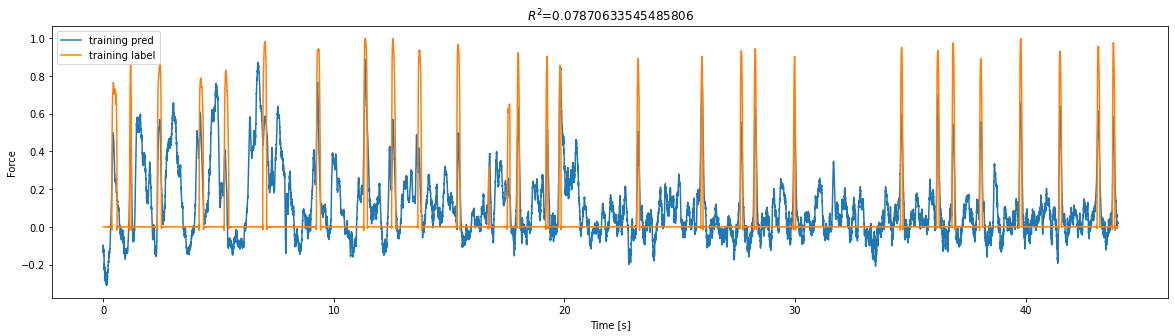

In [36]:
x_ = np.arange(0, pr_train.shape[0], 1)*0.001
plt.figure(figsize=(20,5))
plt.plot(x_, pr_train, label="training pred")
plt.plot(x_, y_train_, label="training label")
plt.title(r"$R^2$"+"="+str(metrics.r2_score(y_train_, pr_train)))
plt.xlabel("Time [s]")
plt.ylabel("Force")
plt.legend()

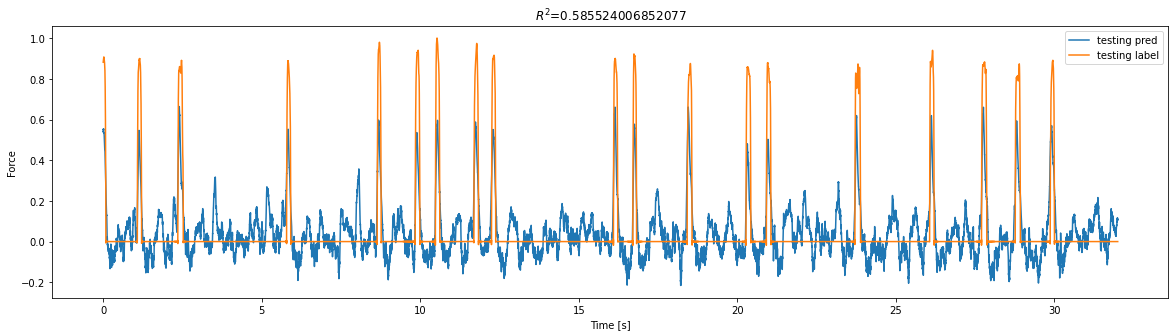

In [37]:
x_ = np.arange(0, pr_test.shape[0], 1)*0.001
plt.figure(figsize=(20,5))
plt.plot(x_, pr_test, label="testing pred")
plt.plot(x_, y_test_, label="testing label")
plt.xlabel("Time [s]")
plt.ylabel("Force")
plt.title(r"$R^2$"+"="+str(metrics.r2_score(y_test_, pr_test)))
plt.legend()

### NOW: do not rebalance the data

In [18]:
model  = EEGNet(Chans = chans, Samples = samples, kernLength=kernLength)
model.compile(loss = "mae", optimizer = keras.optimizers.Adam(),\
              metrics=[correlation__])

es = EarlyStopping(monitor='val_correlation__', mode='max', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_correlation__', mode='max', verbose=1, save_best_only=True)

In [19]:
REBALANCE_THR = 0.1
with tf.device('/gpu:0'):
    gen_tr = label_generator.generator_regression(X_train, y_train, batch_size, \
                        samples, rebalance=False, rebalanced_thr=REBALANCE_THR)
    gen_val = label_generator.generator_regression(X_val, y_val, batch_size, \
                        samples, rebalance=False, rebalanced_thr=REBALANCE_THR)
    hist = model.fit(gen_tr, validation_data=gen_val, steps_per_epoch=int(X_train.shape[0]/batch_size), \
                     epochs=100, validation_steps=int(X_val.shape[0]/batch_size), callbacks=[es,mc])
model = load_model('best_model.h5', custom_objects={'correlation__': correlation__})

# get the training set label and predictions with rebalance = False
gen_ = label_generator.generator_regression(X_train, y_train, batch_size, \
                                            samples, rebalance=False, rebalanced_thr=0.1)
pr_train = model.predict(gen_, steps=int(X_train.shape[0]/batch_size))[:,0]
gen_ = label_generator.generator_regression(X_train, y_train, batch_size, \
                        samples, rebalance=False)
y_train_ = get_label_from_gen(gen_, X_train, batch_size)

# get the test set label and predictions
gen_ = label_generator.generator_regression(X_test, y_test, batch_size, \
                        samples, rebalance=False)
pr_test = model.predict(gen_, steps=int(X_test.shape[0]/batch_size))[:,0]
gen_ = label_generator.generator_regression(X_test, y_test, batch_size, \
                        samples, rebalance=False)
y_test_ = get_label_from_gen(gen_, X_test, batch_size)

Train for 11 steps, validate for 4 steps
Epoch 1/100
10/11 [==========================>...] - ETA: 0s - loss: 0.1586 - correlation__: 0.0236
Epoch 00001: val_correlation__ improved from -inf to 0.07956, saving model to best_model.h5
11/11 [==============================] - 3s 276ms/step - loss: 0.1564 - correlation__: 0.0076 - val_loss: 0.0571 - val_correlation__: 0.0796
Epoch 2/100
10/11 [==========================>...] - ETA: 0s - loss: 0.0807 - correlation__: 0.1903
Epoch 00002: val_correlation__ improved from 0.07956 to 0.23736, saving model to best_model.h5
11/11 [==============================] - 2s 153ms/step - loss: 0.0822 - correlation__: 0.1880 - val_loss: 0.0621 - val_correlation__: 0.2374
Epoch 3/100
10/11 [==========================>...] - ETA: 0s - loss: 0.0717 - correlation__: 0.2384
Epoch 00003: val_correlation__ did not improve from 0.23736
11/11 [==============================] - 2s 211ms/step - loss: 0.0736 - correlation__: 0.2182 - val_loss: 0.0562 - val_correlation

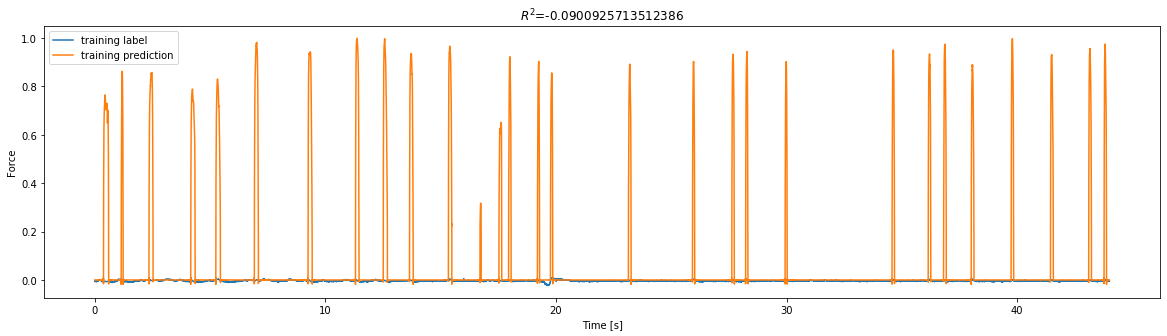

In [20]:
x_ = np.arange(0, pr_train.shape[0], 1)*0.001
plt.figure(figsize=(20,5))
plt.plot(x_, pr_train, label="training label")
plt.plot(x_, y_train_, label="training prediction")
plt.title(r"$R^2$"+"="+str(metrics.r2_score(y_train_, pr_train)))
plt.xlabel("Time [s]")
plt.ylabel("Force")
plt.legend()

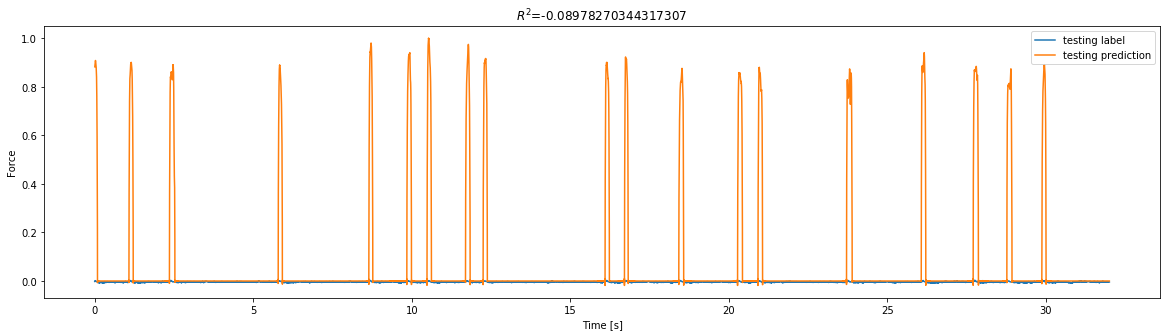

In [21]:
x_ = np.arange(0, pr_test.shape[0], 1)*0.001
plt.figure(figsize=(20,5))
plt.plot(x_, pr_test, label="testing label")
plt.plot(x_, y_test_, label="testing prediction")
plt.xlabel("Time [s]")
plt.ylabel("Force")
plt.title(r"$R^2$"+"="+str(metrics.r2_score(y_test_, pr_test)))
plt.legend()

# CNN 

In [8]:
import keras
from keras.models import Sequential, Model
from keras.layers import *
from keras.optimizers import Adam, Adadelta, Adagrad, SGD

In [9]:
def make_cnnModel(input_shape = (1,6,128), summary = True
                 ,n_conv = 3 ,conv_units = [32,64,128] 
                 ,kernel_sizes = [[64,1],[64,1],[64,1]] ,conv_activation = ReLU, conv = Conv2D
                 ,pool_func = MaxPool2D ,pool = [0,1,1]
                 ,n_dense = 2, dense_units = [200,120], dense_activation = ReLU
                 ,output_layer = Dense, output_units = 2, output_activation = None
                 ,ch_first = True
                 ,batch_norm = False):
    
    if ch_first:
        keras.backend.set_image_data_format('channels_first')
    
    model = Sequential()
    model.add(Input(input_shape))
#     model.add(Permute((2,1,3) ))

    for i in range(n_conv):
        model.add(conv(conv_units[i], kernel_sizes[i], padding= 'same'))
        model.add(conv_activation())
        if batch_norm:
            model.add(BatchNormalization())

#         model.add(DepthwiseConv2D(conv_units[i], kernel_sizes[i]))
        if pool[i] == 1:
            model.add(pool_func(pool_size = (2), strides = (2), padding = 'same'))
    
#     for i in range(n_conv):
#         model.add(DepthwiseConv2D(conv_units[i], kernel_sizes[i]))
#         model.add(conv_activation())
        
    
    
    
    model.add(Flatten())        
    
    
    for i in range(n_dense):
        model.add(Dense(dense_units[i]))
        model.add(dense_activation())
        
              
    model.add(output_layer(output_units, activation = 'sigmoid') )
    
    
    if summary:
        model.summary()
        
    return model

In [12]:
cnn = make_cnnModel()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 6, 128)        2080      
_________________________________________________________________
re_lu (ReLU)                 (None, 32, 6, 128)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 6, 128)        131136    
_________________________________________________________________
re_lu_1 (ReLU)               (None, 64, 6, 128)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 3, 64)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 3, 64)        524416    
_________________________________________________________________
re_lu_2 (ReLU)               (None, 128, 3, 64)        0

In [60]:
cnn.compile(Adam(), loss = 'mae', metrics=[correlation__])

In [61]:
es = EarlyStopping(monitor='val_correlation__', mode='max', verbose=1, patience=5)
mc = ModelCheckpoint('best_cnn_model.h5', monitor='val_correlation__', mode='max', verbose=1, save_best_only=True)

In [63]:
REBALANCE_THR = 0.1

gen_tr = generator_regression(X_train, y_train, batch_size, \
                    samples, rebalance=True, rebalanced_thr=REBALANCE_THR)
gen_val = generator_regression(X_val, y_val, batch_size, \
                    samples, rebalance=True, rebalanced_thr=REBALANCE_THR)
with tf.device('/gpu:0'):
    hist = cnn.fit(gen_tr, validation_data=gen_val, steps_per_epoch=int(X_train.shape[0]/batch_size), \
                     epochs=100, validation_steps=int(X_val.shape[0]/batch_size), callbacks=[mc])
model = load_model('best_cnn_model.h5', custom_objects={'correlation__': correlation__})

# get the training set label and predictions with rebalance = False
gen_ = generator_regression(X_train, y_train, batch_size, \
                                            samples, rebalance=False, rebalanced_thr=0.1)
pr_train = cnn.predict(gen_, steps=int(X_train.shape[0]/batch_size))[:,0]
gen_ = generator_regression(X_train, y_train, batch_size, \
                        samples, rebalance=False)
y_train_ = get_label_from_gen(gen_, X_train, batch_size)

# get the test set label and predictions
gen_ = generator_regression(X_test, y_test, batch_size, \
                        samples, rebalance=False)
pr_test = cnn.predict(gen_, steps=int(X_test.shape[0]/batch_size))[:,0]
gen_ = generator_regression(X_test, y_test, batch_size, \
                        samples, rebalance=False)
y_test_ = get_label_from_gen(gen_, X_test, batch_size)

Epoch 1/100
11/11 [==============================] - ETA: 0s - loss: 0.1279 - correlation__: 0.8286
Epoch 00001: val_correlation__ did not improve from 0.81961
11/11 [==============================] - 10s 952ms/step - loss: 0.1279 - correlation__: 0.8286 - val_loss: 0.1417 - val_correlation__: 0.7643
Epoch 2/100
11/11 [==============================] - ETA: 0s - loss: 0.1193 - correlation__: 0.8342
Epoch 00002: val_correlation__ did not improve from 0.81961
11/11 [==============================] - 10s 939ms/step - loss: 0.1193 - correlation__: 0.8342 - val_loss: 0.1454 - val_correlation__: 0.7642
Epoch 3/100
11/11 [==============================] - ETA: 0s - loss: 0.1067 - correlation__: 0.8592
Epoch 00003: val_correlation__ did not improve from 0.81961
11/11 [==============================] - 10s 936ms/step - loss: 0.1067 - correlation__: 0.8592 - val_loss: 0.1361 - val_correlation__: 0.7932
Epoch 4/100
11/11 [==============================] - ETA: 0s - loss: 0.1032 - correlation__: 0

Epoch 27/100
11/11 [==============================] - ETA: 0s - loss: 0.0758 - correlation__: 0.9369
Epoch 00027: val_correlation__ did not improve from 0.85486
11/11 [==============================] - 10s 941ms/step - loss: 0.0758 - correlation__: 0.9369 - val_loss: 0.1341 - val_correlation__: 0.8160
Epoch 28/100
11/11 [==============================] - ETA: 0s - loss: 0.0752 - correlation__: 0.9345
Epoch 00028: val_correlation__ did not improve from 0.85486
11/11 [==============================] - 10s 945ms/step - loss: 0.0752 - correlation__: 0.9345 - val_loss: 0.1185 - val_correlation__: 0.8325
Epoch 29/100
11/11 [==============================] - ETA: 0s - loss: 0.0855 - correlation__: 0.9118
Epoch 00029: val_correlation__ did not improve from 0.85486
11/11 [==============================] - 10s 945ms/step - loss: 0.0855 - correlation__: 0.9118 - val_loss: 0.1218 - val_correlation__: 0.8390
Epoch 30/100
11/11 [==============================] - ETA: 0s - loss: 0.0641 - correlation_

Epoch 54/100
11/11 [==============================] - ETA: 0s - loss: 0.0335 - correlation__: 0.9878
Epoch 00054: val_correlation__ did not improve from 0.87498
11/11 [==============================] - 10s 944ms/step - loss: 0.0335 - correlation__: 0.9878 - val_loss: 0.1195 - val_correlation__: 0.8381
Epoch 55/100
11/11 [==============================] - ETA: 0s - loss: 0.0318 - correlation__: 0.9863
Epoch 00055: val_correlation__ did not improve from 0.87498
11/11 [==============================] - 10s 944ms/step - loss: 0.0318 - correlation__: 0.9863 - val_loss: 0.1175 - val_correlation__: 0.8388
Epoch 56/100
11/11 [==============================] - ETA: 0s - loss: 0.0282 - correlation__: 0.9892
Epoch 00056: val_correlation__ did not improve from 0.87498
11/11 [==============================] - 10s 947ms/step - loss: 0.0282 - correlation__: 0.9892 - val_loss: 0.1156 - val_correlation__: 0.8469
Epoch 57/100
11/11 [==============================] - ETA: 0s - loss: 0.0273 - correlation_

11/11 [==============================] - ETA: 0s - loss: 0.0201 - correlation__: 0.9955
Epoch 00081: val_correlation__ did not improve from 0.87498
11/11 [==============================] - 10s 946ms/step - loss: 0.0201 - correlation__: 0.9955 - val_loss: 0.1228 - val_correlation__: 0.8185
Epoch 82/100
11/11 [==============================] - ETA: 0s - loss: 0.0213 - correlation__: 0.9949
Epoch 00082: val_correlation__ did not improve from 0.87498
11/11 [==============================] - 10s 945ms/step - loss: 0.0213 - correlation__: 0.9949 - val_loss: 0.1407 - val_correlation__: 0.7915
Epoch 83/100
11/11 [==============================] - ETA: 0s - loss: 0.0162 - correlation__: 0.9963
Epoch 00083: val_correlation__ did not improve from 0.87498
11/11 [==============================] - 10s 945ms/step - loss: 0.0162 - correlation__: 0.9963 - val_loss: 0.1327 - val_correlation__: 0.8197
Epoch 84/100
11/11 [==============================] - ETA: 0s - loss: 0.0157 - correlation__: 0.9968
Epo

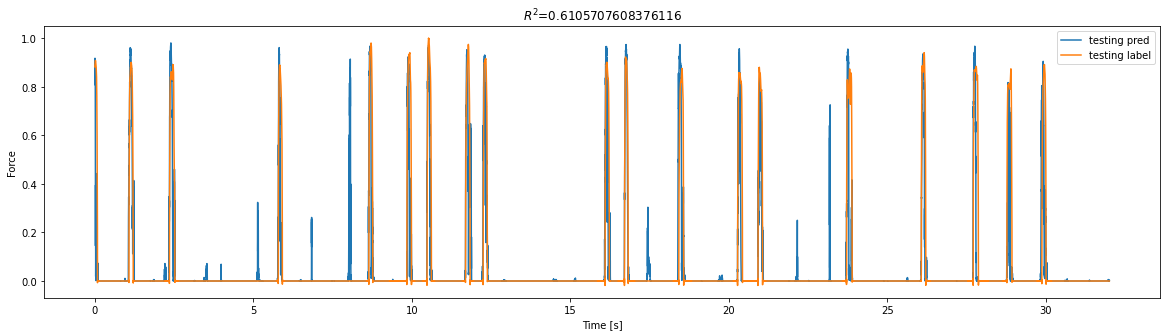

In [64]:
x_ = np.arange(0, pr_test.shape[0], 1)*0.001
plt.figure(figsize=(20,5))
plt.plot(x_, pr_test, label="testing pred")
plt.plot(x_, y_test_, label="testing label")
plt.xlabel("Time [s]")
plt.ylabel("Force")
plt.title(r"$R^2$"+"="+str(metrics.r2_score(y_test_, pr_test)))
plt.legend()

# RNN

In [138]:
def make_rnnModel(input_shape = (1,6,128), summary = True
                  ,n_dense = 3, dense_units = [100,100,200], dense_activation = ReLU
                  ,n_lstm = 2, lstm_units = [128, 128], lstm_activation = None
                  ,output_layer = Dense, output_units = 1, output_activation= None,
                  ch_first = False  ):
    
    
    if ch_first:
        keras.backend.set_image_data_format('channels_first')
        
    if ch_first == False:
        keras.backend.set_image_data_format('channels_last')
            
    
    try:
        len(dense_units) == n_dense
        
    except ValueError:
        print('the length of the dens_unit list should be the same as n_dense')
    
#    input_layer = keras.backend.squeeze(Input(input_shape), axis =1)
    
    #starting the model
    model = Sequential()
    model.add(Input(input_shape))
    model.add(Lambda(keras.backend.squeeze, arguments = {"axis":1}))
    
    
    # masking the dense part of the network
    for i in range(n_dense):
        model.add(Dense(dense_units[i]))
        model.add(dense_activation())
    
    for i in range(n_lstm):
        
        if i+1 == n_lstm:
            model.add(LSTM(lstm_units[0], return_sequences = False))
        else:
            model.add(LSTM(lstm_units[0],return_sequences = True))
            
        if lstm_activation:
            model.add(lstm_activation())    
    
    
    model.add(output_layer(output_units, activation = 'linear') )
    
    if summary:
        model.summary()
        
    return model

In [139]:
rnn = make_rnnModel() 
rnn.compile(Adam(), loss = 'mae', metrics= [correlation__])

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_12 (Lambda)           (None, 6, 128)            0         
_________________________________________________________________
dense_60 (Dense)             (None, 6, 100)            12900     
_________________________________________________________________
re_lu_66 (ReLU)              (None, 6, 100)            0         
_________________________________________________________________
dense_61 (Dense)             (None, 6, 100)            10100     
_________________________________________________________________
re_lu_67 (ReLU)              (None, 6, 100)            0         
_________________________________________________________________
dense_62 (Dense)             (None, 6, 200)            20200     
_________________________________________________________________
re_lu_68 (ReLU)              (None, 6, 200)          

In [140]:
REBALANCE_THR = 0.1

es = EarlyStopping(monitor='val_correlation__', mode='max', verbose=1, patience=5)
mc = ModelCheckpoint('best_rnn_model.h5', monitor='val_correlation__', mode='max', verbose=1, save_best_only=True)

gen_tr = generator_regression(X_train, y_train, batch_size, \
                    samples, rebalance=True, rebalanced_thr=REBALANCE_THR)
gen_val = generator_regression(X_val, y_val, batch_size, \
                    samples, rebalance=True, rebalanced_thr=REBALANCE_THR)
with tf.device('/gpu:0'):
    hist = rnn.fit(gen_tr, validation_data=gen_val, steps_per_epoch=int(X_train.shape[0]/batch_size), \
                     epochs=100, validation_steps=int(X_val.shape[0]/batch_size), callbacks=[mc])
model = load_model('best_cnn_model.h5', custom_objects={'correlation__': correlation__})

# get the training set label and predictions with rebalance = False
gen_ = generator_regression(X_train, y_train, batch_size, \
                                            samples, rebalance=False, rebalanced_thr=0.1)
pr_train = rnn.predict(gen_, steps=int(X_train.shape[0]/batch_size))[:,0]
gen_ = generator_regression(X_train, y_train, batch_size, \
                        samples, rebalance=False)
y_train_ = get_label_from_gen(gen_, X_train, batch_size)

# get the test set label and predictions
gen_ = generator_regression(X_test, y_test, batch_size, \
                        samples, rebalance=False)
pr_test = rnn.predict(gen_, steps=int(X_test.shape[0]/batch_size))[:,0]
gen_ = generator_regression(X_test, y_test, batch_size, \
                        samples, rebalance=False)
y_test_ = get_label_from_gen(gen_, X_test, batch_size)

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
11/11 [==============================] - ETA: 0s - loss: 0.3001 - correlation__: 0.4457WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001A133554558> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY

Epoch 48/100
11/11 [==============================] - ETA: 0s - loss: 0.0742 - correlation__: 0.9468
Epoch 00048: val_correlation__ did not improve from 0.81472
11/11 [==============================] - 2s 176ms/step - loss: 0.0742 - correlation__: 0.9468 - val_loss: 0.1611 - val_correlation__: 0.7588
Epoch 49/100
11/11 [==============================] - ETA: 0s - loss: 0.0778 - correlation__: 0.9406
Epoch 00049: val_correlation__ did not improve from 0.81472
11/11 [==============================] - 2s 173ms/step - loss: 0.0778 - correlation__: 0.9406 - val_loss: 0.1671 - val_correlation__: 0.7737
Epoch 50/100
11/11 [==============================] - ETA: 0s - loss: 0.0695 - correlation__: 0.9509
Epoch 00050: val_correlation__ did not improve from 0.81472
11/11 [==============================] - 2s 176ms/step - loss: 0.0695 - correlation__: 0.9509 - val_loss: 0.1633 - val_correlation__: 0.7606
Epoch 51/100
11/11 [==============================] - ETA: 0s - loss: 0.0703 - correlation__: 

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


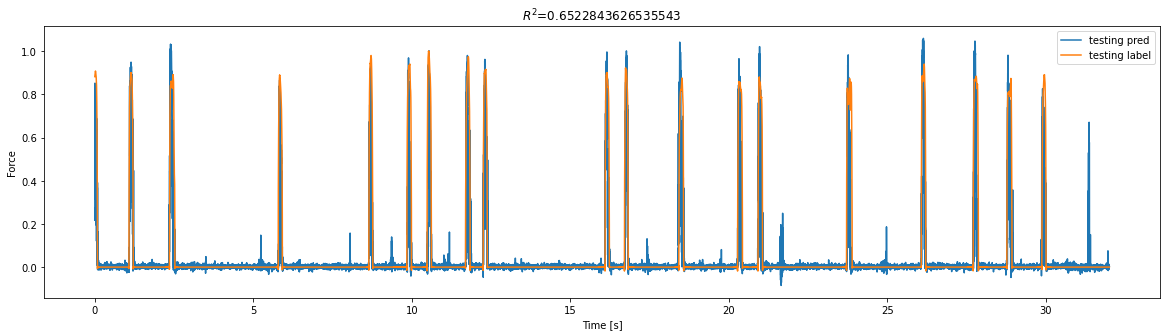

In [123]:
# OLD
x_ = np.arange(0, pr_test.shape[0], 1)*0.001
plt.figure(figsize=(20,5))
plt.plot(x_, pr_test, label="testing pred")
plt.plot(x_, y_test_, label="testing label")
plt.xlabel("Time [s]")
plt.ylabel("Force")
plt.title(r"$R^2$"+"="+str(metrics.r2_score(y_test_, pr_test)))
plt.legend()

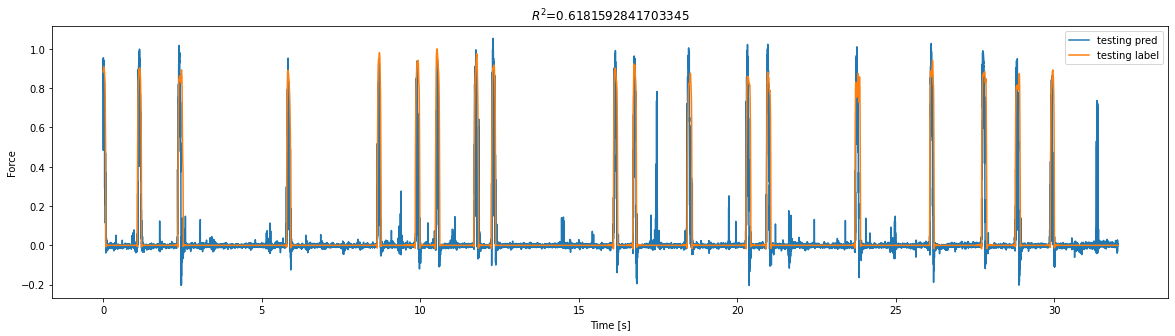

In [141]:
# NEW
x_ = np.arange(0, pr_test.shape[0], 1)*0.001
plt.figure(figsize=(20,5))
plt.plot(x_, pr_test, label="testing pred")
plt.plot(x_, y_test_, label="testing label")
plt.xlabel("Time [s]")
plt.ylabel("Force")
plt.title(r"$R^2$"+"="+str(metrics.r2_score(y_test_, pr_test)))
plt.legend()

# Autoencoder

In [124]:
rnn_backup = rnn
cnn_backup = cnn

In [144]:
def make_aeModel(input_shape = (1,6,128), summary = True
                 ,rnn_model = rnn_backup, cnn_model = cnn_backup,
                 output_n = 1
                                                        ):
    
    input_layer = Input(input_shape)
#    input_layer_extended = tf.keras.backend.expand_dims(input_layer)
    
    rnn_model = Model(rnn_model.input, rnn_model.layers[-2].output, name = 'RNN_Model')
    cnn_model = Model(cnn_model.input, cnn_model.layers[-2].output, name = 'CNN_Model')

    for layer in rnn_model.layers:
        layer.trainable = False
    
    for layer in cnn_model.layers:
        layer.trainable = False
    
    rnn_features = rnn_model(input_layer)
    cnn_features = cnn_model(input_layer)
    
    concat = Concatenate(axis = -1, name = 'Concat')([rnn_features,cnn_features])
    
    x = Dense(200, name = 'Dense_1')(concat)
    x = ReLU()(x)
    x = Dense(100, name = 'Dense_2')(x)
    x = ReLU()(x)
    output = Dense(output_n, activation = 'linear' , name = 'output')(x)
    
    ae = Model(input_layer, output)
    
    
    ae.summary()
    
    return ae

In [145]:
ae = make_aeModel()
ae.compile(Adam(), loss = 'mae', metrics= [correlation__])

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           [(None, 1, 6, 128)]  0                                            
__________________________________________________________________________________________________
RNN_Model (Functional)          (None, 64)           82624       input_29[0][0]                   
__________________________________________________________________________________________________
CNN_Model (Functional)          (None, 120)          2320352     input_29[0][0]                   
__________________________________________________________________________________________________
Concat (Concatenate)            (None, 184)          0           RNN_Model[0][0]                  
                                                                 CNN_Model[0][0]       

In [146]:
REBALANCE_THR = 0.1

es = EarlyStopping(monitor='val_correlation__', mode='max', verbose=1, patience=5)
mc = ModelCheckpoint('best_ae_model.h5', monitor='val_correlation__', mode='max', verbose=1, save_best_only=True)

gen_tr = generator_regression(X_train, y_train, batch_size, \
                    samples, rebalance=True, rebalanced_thr=REBALANCE_THR)
gen_val = generator_regression(X_val, y_val, batch_size, \
                    samples, rebalance=True, rebalanced_thr=REBALANCE_THR)
with tf.device('/gpu:0'):
    hist = ae.fit(gen_tr, validation_data=gen_val, steps_per_epoch=int(X_train.shape[0]/batch_size), \
                     epochs=100, validation_steps=int(X_val.shape[0]/batch_size), callbacks=[mc])
model = load_model('best_cnn_model.h5', custom_objects={'correlation__': correlation__})

# get the training set label and predictions with rebalance = False
gen_ = generator_regression(X_train, y_train, batch_size, \
                                            samples, rebalance=False, rebalanced_thr=0.1)
pr_train = ae.predict(gen_, steps=int(X_train.shape[0]/batch_size))[:,0]
gen_ = generator_regression(X_train, y_train, batch_size, \
                        samples, rebalance=False)
y_train_ = get_label_from_gen(gen_, X_train, batch_size)

# get the test set label and predictions
gen_ = generator_regression(X_test, y_test, batch_size, \
                        samples, rebalance=False)
pr_test = ae.predict(gen_, steps=int(X_test.shape[0]/batch_size))[:,0]
gen_ = generator_regression(X_test, y_test, batch_size, \
                        samples, rebalance=False)
y_test_ = get_label_from_gen(gen_, X_test, batch_size)

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
11/11 [==============================] - ETA: 0s - loss: 0.3162 - correlation__: 0.7038WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001A147C53558> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY

Epoch 22/100
11/11 [==============================] - ETA: 0s - loss: 0.0713 - correlation__: 0.9833
Epoch 00022: val_correlation__ did not improve from 0.83017
11/11 [==============================] - 4s 350ms/step - loss: 0.0713 - correlation__: 0.9833 - val_loss: 0.2097 - val_correlation__: 0.7073
Epoch 23/100
11/11 [==============================] - ETA: 0s - loss: 0.0485 - correlation__: 0.9905
Epoch 00023: val_correlation__ did not improve from 0.83017
11/11 [==============================] - 4s 353ms/step - loss: 0.0485 - correlation__: 0.9905 - val_loss: 0.1670 - val_correlation__: 0.8035
Epoch 24/100
11/11 [==============================] - ETA: 0s - loss: 0.0822 - correlation__: 0.9812
Epoch 00024: val_correlation__ did not improve from 0.83017
11/11 [==============================] - 4s 355ms/step - loss: 0.0822 - correlation__: 0.9812 - val_loss: 0.2007 - val_correlation__: 0.7327
Epoch 25/100
11/11 [==============================] - ETA: 0s - loss: 0.0612 - correlation__: 

11/11 [==============================] - ETA: 0s - loss: 0.0370 - correlation__: 0.9964
Epoch 00076: val_correlation__ did not improve from 0.83017
11/11 [==============================] - 4s 355ms/step - loss: 0.0370 - correlation__: 0.9964 - val_loss: 0.1619 - val_correlation__: 0.7914
Epoch 77/100
11/11 [==============================] - ETA: 0s - loss: 0.0367 - correlation__: 0.9967
Epoch 00077: val_correlation__ did not improve from 0.83017
11/11 [==============================] - 4s 356ms/step - loss: 0.0367 - correlation__: 0.9967 - val_loss: 0.1816 - val_correlation__: 0.8161
Epoch 78/100
11/11 [==============================] - ETA: 0s - loss: 0.0309 - correlation__: 0.9966
Epoch 00078: val_correlation__ did not improve from 0.83017
11/11 [==============================] - 4s 351ms/step - loss: 0.0309 - correlation__: 0.9966 - val_loss: 0.1602 - val_correlation__: 0.8001
Epoch 79/100
11/11 [==============================] - ETA: 0s - loss: 0.0249 - correlation__: 0.9976
Epoch 

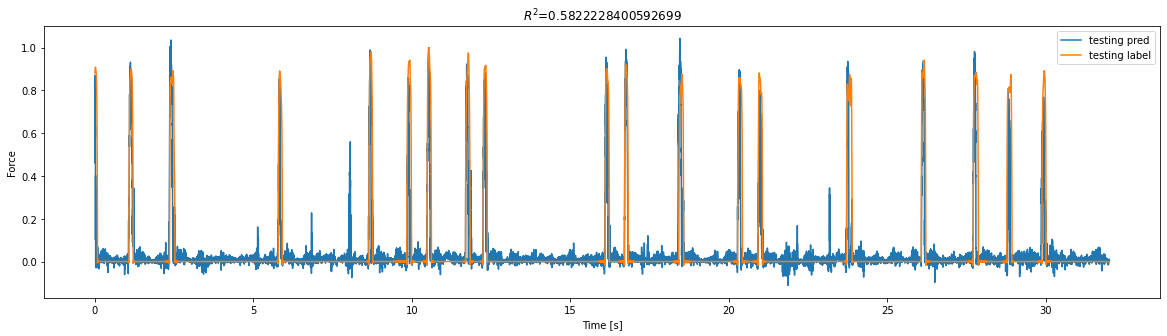

In [132]:
# Old
x_ = np.arange(0, pr_test.shape[0], 1)*0.001
plt.figure(figsize=(20,5))
plt.plot(x_, pr_test, label="testing pred")
plt.plot(x_, y_test_, label="testing label")
plt.xlabel("Time [s]")
plt.ylabel("Force")
plt.title(r"$R^2$"+"="+str(metrics.r2_score(y_test_, pr_test)))
plt.legend()

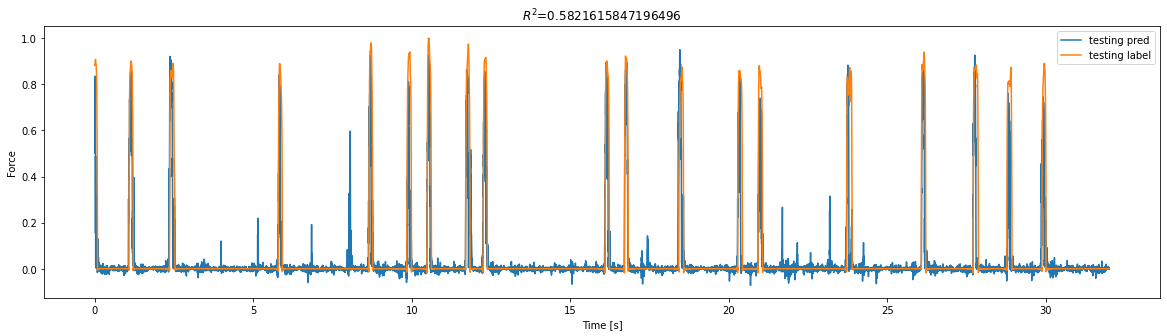

In [147]:
# New
x_ = np.arange(0, pr_test.shape[0], 1)*0.001
plt.figure(figsize=(20,5))
plt.plot(x_, pr_test, label="testing pred")
plt.plot(x_, y_test_, label="testing label")
plt.xlabel("Time [s]")
plt.ylabel("Force")
plt.title(r"$R^2$"+"="+str(metrics.r2_score(y_test_, pr_test)))
plt.legend()

# CNN 128 kernel

In [149]:
cnn_128 = make_cnnModel(kernel_sizes=[[128,1], [128,1], [128,1]], output_units=1)
cnn_128.compile(Adam(), 'mse', metrics=['mae',correlation__])

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 32, 6, 128)        4128      
_________________________________________________________________
re_lu_78 (ReLU)              (None, 32, 6, 128)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 64, 6, 128)        262208    
_________________________________________________________________
re_lu_79 (ReLU)              (None, 64, 6, 128)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 64, 3, 64)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 128, 3, 64)        1048704   
_________________________________________________________________
re_lu_80 (ReLU)              (None, 128, 3, 64)      

In [150]:
REBALANCE_THR = 0.1

es = EarlyStopping(monitor='val_correlation__', mode='max', verbose=1, patience=5)
mc = ModelCheckpoint('best_cnn128_model.h5', monitor='val_correlation__', mode='max', verbose=1, save_best_only=True)

gen_tr = generator_regression(X_train, y_train, batch_size, \
                    samples, rebalance=True, rebalanced_thr=REBALANCE_THR)
gen_val = generator_regression(X_val, y_val, batch_size, \
                    samples, rebalance=True, rebalanced_thr=REBALANCE_THR)
with tf.device('/gpu:0'):
    hist = cnn_128.fit(gen_tr, validation_data=gen_val, steps_per_epoch=int(X_train.shape[0]/batch_size), \
                     epochs=100, validation_steps=int(X_val.shape[0]/batch_size), callbacks=[mc])
model = load_model('best_cnn_model.h5', custom_objects={'correlation__': correlation__})

# get the training set label and predictions with rebalance = False
gen_ = generator_regression(X_train, y_train, batch_size, \
                                            samples, rebalance=False, rebalanced_thr=0.1)
pr_train = cnn_128.predict(gen_, steps=int(X_train.shape[0]/batch_size))[:,0]
gen_ = generator_regression(X_train, y_train, batch_size, \
                        samples, rebalance=False)
y_train_ = get_label_from_gen(gen_, X_train, batch_size)

# get the test set label and predictions
gen_ = generator_regression(X_test, y_test, batch_size, \
                        samples, rebalance=False)
pr_test = cnn_128.predict(gen_, steps=int(X_test.shape[0]/batch_size))[:,0]
gen_ = generator_regression(X_test, y_test, batch_size, \
                        samples, rebalance=False)
y_test_ = get_label_from_gen(gen_, X_test, batch_size)

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
11/11 [==============================] - ETA: 0s - loss: 0.1448 - mae: 0.3389 - correlation__: 0.3714WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001A12050A9D8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOG

Epoch 19/100
11/11 [==============================] - ETA: 0s - loss: 0.0387 - mae: 0.1258 - correlation__: 0.8830
Epoch 00019: val_correlation__ improved from 0.85272 to 0.86059, saving model to best_cnn128_model.h5
11/11 [==============================] - 30s 3s/step - loss: 0.0387 - mae: 0.1258 - correlation__: 0.8830 - val_loss: 0.0415 - val_mae: 0.1368 - val_correlation__: 0.8606
Epoch 20/100
11/11 [==============================] - ETA: 0s - loss: 0.0294 - mae: 0.1070 - correlation__: 0.9043
Epoch 00020: val_correlation__ did not improve from 0.86059
11/11 [==============================] - 30s 3s/step - loss: 0.0294 - mae: 0.1070 - correlation__: 0.9043 - val_loss: 0.0631 - val_mae: 0.1479 - val_correlation__: 0.7873
Epoch 21/100
11/11 [==============================] - ETA: 0s - loss: 0.0260 - mae: 0.0957 - correlation__: 0.9172
Epoch 00021: val_correlation__ did not improve from 0.86059
11/11 [==============================] - 30s 3s/step - loss: 0.0260 - mae: 0.0957 - correla

Epoch 42/100
11/11 [==============================] - ETA: 0s - loss: 0.0177 - mae: 0.0735 - correlation__: 0.9531
Epoch 00042: val_correlation__ did not improve from 0.87265
11/11 [==============================] - 30s 3s/step - loss: 0.0177 - mae: 0.0735 - correlation__: 0.9531 - val_loss: 0.0462 - val_mae: 0.1216 - val_correlation__: 0.8502
Epoch 43/100
11/11 [==============================] - ETA: 0s - loss: 0.0191 - mae: 0.0828 - correlation__: 0.9492
Epoch 00043: val_correlation__ did not improve from 0.87265
11/11 [==============================] - 30s 3s/step - loss: 0.0191 - mae: 0.0828 - correlation__: 0.9492 - val_loss: 0.0477 - val_mae: 0.1205 - val_correlation__: 0.8471
Epoch 44/100
11/11 [==============================] - ETA: 0s - loss: 0.0175 - mae: 0.0776 - correlation__: 0.9456
Epoch 00044: val_correlation__ did not improve from 0.87265
11/11 [==============================] - 30s 3s/step - loss: 0.0175 - mae: 0.0776 - correlation__: 0.9456 - val_loss: 0.0534 - val_ma

Epoch 66/100
11/11 [==============================] - ETA: 0s - loss: 0.0024 - mae: 0.0269 - correlation__: 0.9931
Epoch 00066: val_correlation__ did not improve from 0.87455
11/11 [==============================] - 30s 3s/step - loss: 0.0024 - mae: 0.0269 - correlation__: 0.9931 - val_loss: 0.0501 - val_mae: 0.1284 - val_correlation__: 0.8536
Epoch 67/100
11/11 [==============================] - ETA: 0s - loss: 0.0030 - mae: 0.0299 - correlation__: 0.9916
Epoch 00067: val_correlation__ did not improve from 0.87455
11/11 [==============================] - 30s 3s/step - loss: 0.0030 - mae: 0.0299 - correlation__: 0.9916 - val_loss: 0.0506 - val_mae: 0.1339 - val_correlation__: 0.8593
Epoch 68/100
11/11 [==============================] - ETA: 0s - loss: 0.0025 - mae: 0.0286 - correlation__: 0.9925
Epoch 00068: val_correlation__ did not improve from 0.87455
11/11 [==============================] - 30s 3s/step - loss: 0.0025 - mae: 0.0286 - correlation__: 0.9925 - val_loss: 0.0465 - val_ma

Epoch 90/100
11/11 [==============================] - ETA: 0s - loss: 0.0024 - mae: 0.0289 - correlation__: 0.9929
Epoch 00090: val_correlation__ did not improve from 0.87455
11/11 [==============================] - 30s 3s/step - loss: 0.0024 - mae: 0.0289 - correlation__: 0.9929 - val_loss: 0.0496 - val_mae: 0.1289 - val_correlation__: 0.8535
Epoch 91/100
11/11 [==============================] - ETA: 0s - loss: 0.0020 - mae: 0.0256 - correlation__: 0.9940
Epoch 00091: val_correlation__ did not improve from 0.87455
11/11 [==============================] - 30s 3s/step - loss: 0.0020 - mae: 0.0256 - correlation__: 0.9940 - val_loss: 0.0453 - val_mae: 0.1232 - val_correlation__: 0.8702
Epoch 92/100
11/11 [==============================] - ETA: 0s - loss: 0.0015 - mae: 0.0227 - correlation__: 0.9955
Epoch 00092: val_correlation__ did not improve from 0.87455
11/11 [==============================] - 30s 3s/step - loss: 0.0015 - mae: 0.0227 - correlation__: 0.9955 - val_loss: 0.0544 - val_ma

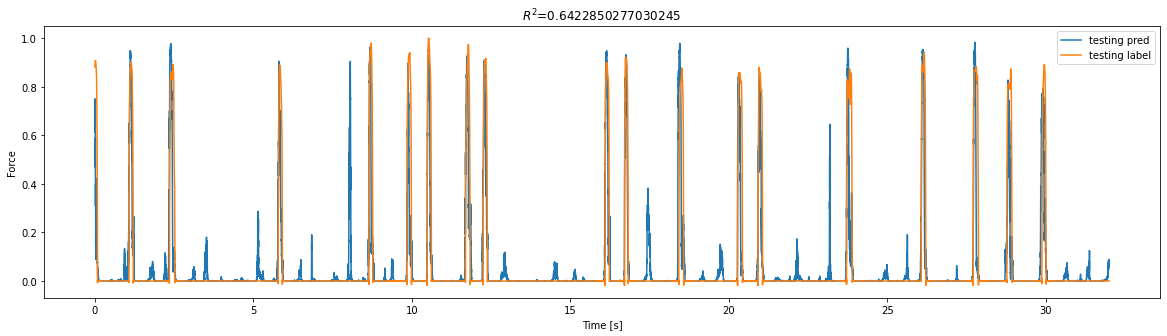

In [151]:

x_ = np.arange(0, pr_test.shape[0], 1)*0.001
plt.figure(figsize=(20,5))
plt.plot(x_, pr_test, label="testing pred")
plt.plot(x_, y_test_, label="testing label")
plt.xlabel("Time [s]")
plt.ylabel("Force")
plt.title(r"$R^2$"+"="+str(metrics.r2_score(y_test_, pr_test)))
plt.legend()

# CNN 128x3

In [20]:
cnn_128x3 = make_cnnModel(kernel_sizes=[[128,3], [128,3], [128,3]], output_units=1)
cnn_128x3.compile(Adam(), 'mse', metrics=['mae',correlation__])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 6, 128)        12320     
_________________________________________________________________
re_lu (ReLU)                 (None, 32, 6, 128)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 6, 128)        786496    
_________________________________________________________________
re_lu_1 (ReLU)               (None, 64, 6, 128)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 3, 64)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 3, 64)        3145856   
_________________________________________________________________
re_lu_2 (ReLU)               (None, 128, 3, 64)        0

In [21]:
REBALANCE_THR = 0.1

es = EarlyStopping(monitor='val_correlation__', mode='max', verbose=1, patience=5)
mc = ModelCheckpoint('best_cnn128x3_model.h5', monitor='val_correlation__', mode='max', verbose=1, save_best_only=True)

gen_tr = generator_regression(X_train, y_train, batch_size, \
                    samples, rebalance=True, rebalanced_thr=REBALANCE_THR)
gen_val = generator_regression(X_val, y_val, batch_size, \
                    samples, rebalance=True, rebalanced_thr=REBALANCE_THR)
with tf.device('/gpu:0'):
    hist = cnn_128x3.fit(gen_tr, validation_data=gen_val, steps_per_epoch=int(X_train.shape[0]/batch_size), \
                     epochs=100, validation_steps=int(X_val.shape[0]/batch_size), callbacks=[mc])
#cnn_128x3 = load_model('best_cnn128x3_model.h5', custom_objects={'correlation__': correlation__})

# get the training set label and predictions with rebalance = False
gen_ = generator_regression(X_train, y_train, batch_size, \
                                            samples, rebalance=False, rebalanced_thr=0.1)
pr_train = cnn_128x3.predict(gen_, steps=int(X_train.shape[0]/batch_size))[:,0]
gen_ = generator_regression(X_train, y_train, batch_size, \
                        samples, rebalance=False)
y_train_ = get_label_from_gen(gen_, X_train, batch_size)

# get the test set label and predictions
gen_ = generator_regression(X_test, y_test, batch_size, \
                        samples, rebalance=False)
pr_test = cnn_128x3.predict(gen_, steps=int(X_test.shape[0]/batch_size))[:,0]
gen_ = generator_regression(X_test, y_test, batch_size, \
                        samples, rebalance=False)
y_test_ = get_label_from_gen(gen_, X_test, batch_size)

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing 

Epoch 16/100
11/11 [==============================] - ETA: 0s - loss: 0.0282 - mae: 0.0965 - correlation__: 0.9050
Epoch 00016: val_correlation__ improved from 0.84810 to 0.84873, saving model to best_cnn128x3_model.h5
11/11 [==============================] - 54s 5s/step - loss: 0.0282 - mae: 0.0965 - correlation__: 0.9050 - val_loss: 0.0432 - val_mae: 0.1285 - val_correlation__: 0.8487
Epoch 17/100
11/11 [==============================] - ETA: 0s - loss: 0.0322 - mae: 0.1098 - correlation__: 0.9092
Epoch 00017: val_correlation__ did not improve from 0.84873
11/11 [==============================] - 53s 5s/step - loss: 0.0322 - mae: 0.1098 - correlation__: 0.9092 - val_loss: 0.0537 - val_mae: 0.1463 - val_correlation__: 0.8109
Epoch 18/100
11/11 [==============================] - ETA: 0s - loss: 0.0382 - mae: 0.1269 - correlation__: 0.8937
Epoch 00018: val_correlation__ improved from 0.84873 to 0.87696, saving model to best_cnn128x3_model.h5
11/11 [==============================] - 54s 

Epoch 39/100
11/11 [==============================] - ETA: 0s - loss: 0.0568 - mae: 0.1360 - correlation__: 0.8659
Epoch 00039: val_correlation__ did not improve from 0.88494
11/11 [==============================] - 54s 5s/step - loss: 0.0568 - mae: 0.1360 - correlation__: 0.8659 - val_loss: 0.0414 - val_mae: 0.1219 - val_correlation__: 0.8660
Epoch 40/100
11/11 [==============================] - ETA: 0s - loss: 0.0235 - mae: 0.0906 - correlation__: 0.9208
Epoch 00040: val_correlation__ did not improve from 0.88494
11/11 [==============================] - 54s 5s/step - loss: 0.0235 - mae: 0.0906 - correlation__: 0.9208 - val_loss: 0.0382 - val_mae: 0.1140 - val_correlation__: 0.8669
Epoch 41/100
11/11 [==============================] - ETA: 0s - loss: 0.0176 - mae: 0.0774 - correlation__: 0.9418
Epoch 00041: val_correlation__ did not improve from 0.88494
11/11 [==============================] - 54s 5s/step - loss: 0.0176 - mae: 0.0774 - correlation__: 0.9418 - val_loss: 0.0363 - val_ma

Epoch 62/100
11/11 [==============================] - ETA: 0s - loss: 0.0031 - mae: 0.0282 - correlation__: 0.9899
Epoch 00062: val_correlation__ did not improve from 0.90678
11/11 [==============================] - 53s 5s/step - loss: 0.0031 - mae: 0.0282 - correlation__: 0.9899 - val_loss: 0.0320 - val_mae: 0.1010 - val_correlation__: 0.8973
Epoch 63/100
11/11 [==============================] - ETA: 0s - loss: 0.0027 - mae: 0.0269 - correlation__: 0.9914
Epoch 00063: val_correlation__ did not improve from 0.90678
11/11 [==============================] - 53s 5s/step - loss: 0.0027 - mae: 0.0269 - correlation__: 0.9914 - val_loss: 0.0326 - val_mae: 0.1028 - val_correlation__: 0.8953
Epoch 64/100
11/11 [==============================] - ETA: 0s - loss: 0.0027 - mae: 0.0260 - correlation__: 0.9913
Epoch 00064: val_correlation__ did not improve from 0.90678
11/11 [==============================] - 53s 5s/step - loss: 0.0027 - mae: 0.0260 - correlation__: 0.9913 - val_loss: 0.0336 - val_ma

Epoch 86/100
11/11 [==============================] - ETA: 0s - loss: 8.6310e-04 - mae: 0.0154 - correlation__: 0.9975
Epoch 00086: val_correlation__ did not improve from 0.90678
11/11 [==============================] - 53s 5s/step - loss: 8.6310e-04 - mae: 0.0154 - correlation__: 0.9975 - val_loss: 0.0335 - val_mae: 0.1049 - val_correlation__: 0.8945
Epoch 87/100
11/11 [==============================] - ETA: 0s - loss: 6.6558e-04 - mae: 0.0135 - correlation__: 0.9980
Epoch 00087: val_correlation__ did not improve from 0.90678
11/11 [==============================] - 53s 5s/step - loss: 6.6558e-04 - mae: 0.0135 - correlation__: 0.9980 - val_loss: 0.0346 - val_mae: 0.1085 - val_correlation__: 0.8914
Epoch 88/100
11/11 [==============================] - ETA: 0s - loss: 5.6084e-04 - mae: 0.0117 - correlation__: 0.9983
Epoch 00088: val_correlation__ did not improve from 0.90678
11/11 [==============================] - 53s 5s/step - loss: 5.6084e-04 - mae: 0.0117 - correlation__: 0.9983 - v

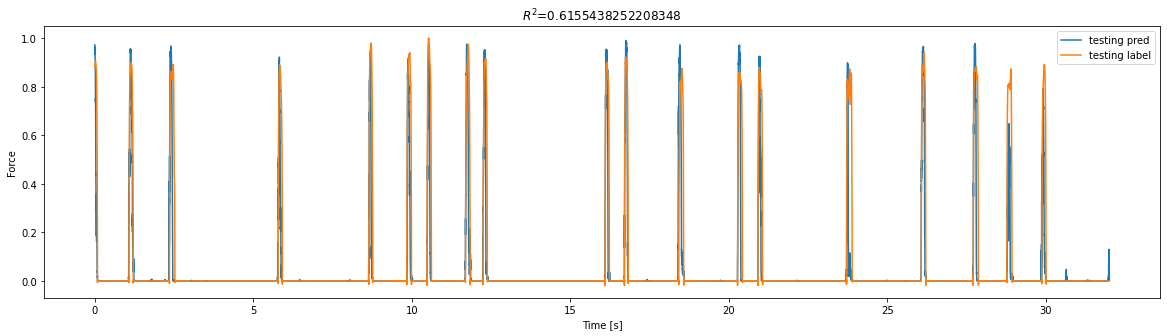

In [22]:

x_ = np.arange(0, pr_test.shape[0], 1)*0.001
plt.figure(figsize=(20,5))
plt.plot(x_, pr_test, label="testing pred")
plt.plot(x_, y_test_, label="testing label")
plt.xlabel("Time [s]")
plt.ylabel("Force")
plt.title(r"$R^2$"+"="+str(metrics.r2_score(y_test_, pr_test)))
plt.legend()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


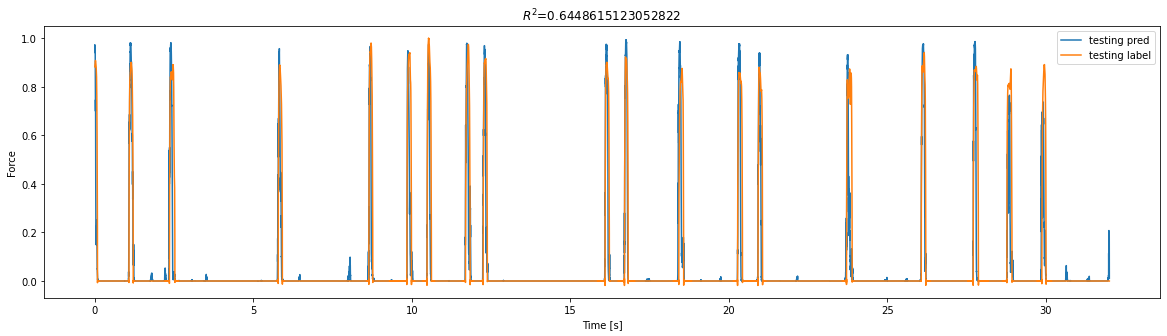

In [92]:
model = load_model('best_cnn128x3_model.h5', custom_objects={'correlation__': correlation__})

# get the test set label and predictions
gen_ = generator_regression(X_test, y_test, batch_size, \
                        samples, rebalance=False)
pr_test = model.predict(gen_, steps=int(X_test.shape[0]/batch_size))[:,0]
gen_ = generator_regression(X_test, y_test, batch_size, \
                        samples, rebalance=False)
y_test_ = get_label_from_gen(gen_, X_test, batch_size)


x_ = np.arange(0, pr_test.shape[0], 1)*0.001
plt.figure(figsize=(20,5))
plt.plot(x_, pr_test, label="testing pred")
plt.plot(x_, y_test_, label="testing label")
plt.xlabel("Time [s]")
plt.ylabel("Force")
plt.title(r"$R^2$"+"="+str(metrics.r2_score(y_test_, pr_test)))
plt.legend()

In [153]:
REBALANCE_THR = 0.1

es = EarlyStopping(monitor='val_correlation__', mode='max', verbose=1, patience=5)
mc = ModelCheckpoint('best_cnn128x3_model.h5', monitor='val_correlation__', mode='max', verbose=1, save_best_only=True)

gen_tr = generator_regression(X_train, y_train, batch_size, \
                    samples, rebalance=True, rebalanced_thr=REBALANCE_THR)
gen_val = generator_regression(X_val, y_val, batch_size, \
                    samples, rebalance=True, rebalanced_thr=REBALANCE_THR)
with tf.device('/gpu:0'):
    hist = cnn_128x23.fit(gen_tr, validation_data=gen_val, steps_per_epoch=int(X_train.shape[0]/batch_size), \
                     epochs=100, validation_steps=int(X_val.shape[0]/batch_size), callbacks=[mc])
#model = load_model('best_cnn_model.h5', custom_objects={'correlation__': correlation__})

# get the training set label and predictions with rebalance = False
gen_ = generator_regression(X_train, y_train, batch_size, \
                                            samples, rebalance=False, rebalanced_thr=0.1)
pr_train = cnn_128x3.predict(gen_, steps=int(X_train.shape[0]/batch_size))[:,0]
gen_ = generator_regression(X_train, y_train, batch_size, \
                        samples, rebalance=False)
y_train_ = get_label_from_gen(gen_, X_train, batch_size)

# get the test set label and predictions
gen_ = generator_regression(X_test, y_test, batch_size, \
                        samples, rebalance=False)
pr_test = cnn_128x3.predict(gen_, steps=int(X_test.shape[0]/batch_size))[:,0]
gen_ = generator_regression(X_test, y_test, batch_size, \
                        samples, rebalance=False)
y_test_ = get_label_from_gen(gen_, X_test, batch_size)

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
11/11 [==============================] - ETA: 0s - loss: 0.1477 - mae: 0.3404 - correlation__: 0.2838WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001A11CB86318> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOG

Epoch 18/100
11/11 [==============================] - ETA: 0s - loss: 0.0311 - mae: 0.1059 - correlation__: 0.8955
Epoch 00018: val_correlation__ improved from 0.84990 to 0.85175, saving model to best_cnn128x2_model.h5
11/11 [==============================] - 69s 6s/step - loss: 0.0311 - mae: 0.1059 - correlation__: 0.8955 - val_loss: 0.0457 - val_mae: 0.1383 - val_correlation__: 0.8517
Epoch 19/100
11/11 [==============================] - ETA: 0s - loss: 0.0255 - mae: 0.0990 - correlation__: 0.9226
Epoch 00019: val_correlation__ did not improve from 0.85175
11/11 [==============================] - 71s 6s/step - loss: 0.0255 - mae: 0.0990 - correlation__: 0.9226 - val_loss: 0.0506 - val_mae: 0.1304 - val_correlation__: 0.8332
Epoch 20/100
11/11 [==============================] - ETA: 0s - loss: 0.0370 - mae: 0.1201 - correlation__: 0.8953
Epoch 00020: val_correlation__ did not improve from 0.85175
11/11 [==============================] - 69s 6s/step - loss: 0.0370 - mae: 0.1201 - corre

Epoch 65/100
11/11 [==============================] - ETA: 0s - loss: 0.0026 - mae: 0.0278 - correlation__: 0.9930
Epoch 00065: val_correlation__ did not improve from 0.86257
11/11 [==============================] - 69s 6s/step - loss: 0.0026 - mae: 0.0278 - correlation__: 0.9930 - val_loss: 0.0508 - val_mae: 0.1274 - val_correlation__: 0.8246
Epoch 66/100
11/11 [==============================] - ETA: 0s - loss: 0.0023 - mae: 0.0273 - correlation__: 0.9939
Epoch 00066: val_correlation__ did not improve from 0.86257
11/11 [==============================] - 69s 6s/step - loss: 0.0023 - mae: 0.0273 - correlation__: 0.9939 - val_loss: 0.0477 - val_mae: 0.1168 - val_correlation__: 0.8430
Epoch 67/100
11/11 [==============================] - ETA: 0s - loss: 0.0022 - mae: 0.0253 - correlation__: 0.9938
Epoch 00067: val_correlation__ did not improve from 0.86257
11/11 [==============================] - 68s 6s/step - loss: 0.0022 - mae: 0.0253 - correlation__: 0.9938 - val_loss: 0.0510 - val_ma

Epoch 89/100
11/11 [==============================] - ETA: 0s - loss: 0.0014 - mae: 0.0216 - correlation__: 0.9968
Epoch 00089: val_correlation__ did not improve from 0.86257
11/11 [==============================] - 70s 6s/step - loss: 0.0014 - mae: 0.0216 - correlation__: 0.9968 - val_loss: 0.0533 - val_mae: 0.1276 - val_correlation__: 0.8287
Epoch 90/100
11/11 [==============================] - ETA: 0s - loss: 0.0013 - mae: 0.0205 - correlation__: 0.9970
Epoch 00090: val_correlation__ did not improve from 0.86257
11/11 [==============================] - 72s 7s/step - loss: 0.0013 - mae: 0.0205 - correlation__: 0.9970 - val_loss: 0.0558 - val_mae: 0.1320 - val_correlation__: 0.8257
Epoch 91/100
11/11 [==============================] - ETA: 0s - loss: 7.5858e-04 - mae: 0.0158 - correlation__: 0.9979
Epoch 00091: val_correlation__ did not improve from 0.86257
11/11 [==============================] - 70s 6s/step - loss: 7.5858e-04 - mae: 0.0158 - correlation__: 0.9979 - val_loss: 0.0618 

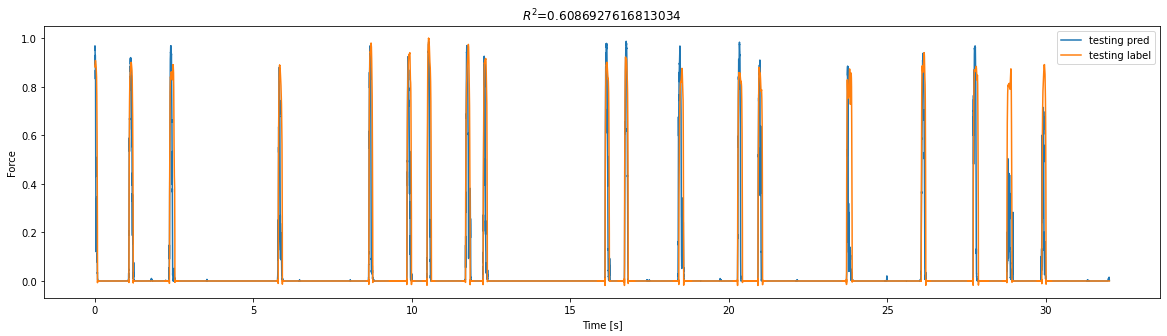

In [154]:

x_ = np.arange(0, pr_test.shape[0], 1)*0.001
plt.figure(figsize=(20,5))
plt.plot(x_, pr_test, label="testing pred")
plt.plot(x_, y_test_, label="testing label")
plt.xlabel("Time [s]")
plt.ylabel("Force")
plt.title(r"$R^2$"+"="+str(metrics.r2_score(y_test_, pr_test)))
plt.legend()

# CNN 128x2

In [155]:
cnn_128x2_ = make_cnnModel(kernel_sizes=[[128,2], [128,2], [128,2]], output_units=1)
cnn_128x2_.compile(Adam(), 'mse', metrics=['mae',correlation__])

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 32, 6, 128)        8224      
_________________________________________________________________
re_lu_88 (ReLU)              (None, 32, 6, 128)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 64, 6, 128)        524352    
_________________________________________________________________
re_lu_89 (ReLU)              (None, 64, 6, 128)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 64, 3, 64)         0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 128, 3, 64)        2097280   
_________________________________________________________________
re_lu_90 (ReLU)              (None, 128, 3, 64)      

In [156]:
REBALANCE_THR = 0.1

es = EarlyStopping(monitor='val_correlation__', mode='max', verbose=1, patience=5)
mc = ModelCheckpoint('best_cnn128x2*_model.h5', monitor='val_correlation__', mode='max', verbose=1, save_best_only=True)

gen_tr = generator_regression(X_train, y_train, batch_size, \
                    samples, rebalance=True, rebalanced_thr=REBALANCE_THR)
gen_val = generator_regression(X_val, y_val, batch_size, \
                    samples, rebalance=True, rebalanced_thr=REBALANCE_THR)
with tf.device('/gpu:0'):
    hist = cnn_128x2_.fit(gen_tr, validation_data=gen_val, steps_per_epoch=int(X_train.shape[0]/batch_size), \
                     epochs=100, validation_steps=int(X_val.shape[0]/batch_size), callbacks=[mc])
# model = load_model('best_cnn_model.h5', custom_objects={'correlation__': correlation__})

# get the training set label and predictions with rebalance = False
gen_ = generator_regression(X_train, y_train, batch_size, \
                                            samples, rebalance=False, rebalanced_thr=0.1)
pr_train = cnn_128x2_.predict(gen_, steps=int(X_train.shape[0]/batch_size))[:,0]
gen_ = generator_regression(X_train, y_train, batch_size, \
                        samples, rebalance=False)
y_train_ = get_label_from_gen(gen_, X_train, batch_size)

# get the test set label and predictions
gen_ = generator_regression(X_test, y_test, batch_size, \
                        samples, rebalance=False)
pr_test = cnn_128x2_.predict(gen_, steps=int(X_test.shape[0]/batch_size))[:,0]
gen_ = generator_regression(X_test, y_test, batch_size, \
                        samples, rebalance=False)
y_test_ = get_label_from_gen(gen_, X_test, batch_size)

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
11/11 [==============================] - ETA: 0s - loss: 0.1618 - mae: 0.3614 - correlation__: 0.3159WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001A12017A948> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOG

Epoch 18/100
11/11 [==============================] - ETA: 0s - loss: 0.0280 - mae: 0.0971 - correlation__: 0.9158
Epoch 00018: val_correlation__ did not improve from 0.81809
11/11 [==============================] - 37s 3s/step - loss: 0.0280 - mae: 0.0971 - correlation__: 0.9158 - val_loss: 0.0565 - val_mae: 0.1399 - val_correlation__: 0.8149
Epoch 19/100
11/11 [==============================] - ETA: 0s - loss: 0.0263 - mae: 0.0969 - correlation__: 0.9196
Epoch 00019: val_correlation__ improved from 0.81809 to 0.83910, saving model to best_cnn128x2*_model.h5
11/11 [==============================] - 37s 3s/step - loss: 0.0263 - mae: 0.0969 - correlation__: 0.9196 - val_loss: 0.0538 - val_mae: 0.1438 - val_correlation__: 0.8391
Epoch 20/100
11/11 [==============================] - ETA: 0s - loss: 0.0229 - mae: 0.0917 - correlation__: 0.9287
Epoch 00020: val_correlation__ did not improve from 0.83910
11/11 [==============================] - 37s 3s/step - loss: 0.0229 - mae: 0.0917 - corr

Epoch 41/100
11/11 [==============================] - ETA: 0s - loss: 0.0053 - mae: 0.0378 - correlation__: 0.9833
Epoch 00041: val_correlation__ did not improve from 0.85925
11/11 [==============================] - 37s 3s/step - loss: 0.0053 - mae: 0.0378 - correlation__: 0.9833 - val_loss: 0.0496 - val_mae: 0.1262 - val_correlation__: 0.8486
Epoch 42/100
11/11 [==============================] - ETA: 0s - loss: 0.0046 - mae: 0.0363 - correlation__: 0.9853
Epoch 00042: val_correlation__ did not improve from 0.85925
11/11 [==============================] - 37s 3s/step - loss: 0.0046 - mae: 0.0363 - correlation__: 0.9853 - val_loss: 0.0535 - val_mae: 0.1356 - val_correlation__: 0.8298
Epoch 43/100
11/11 [==============================] - ETA: 0s - loss: 0.0042 - mae: 0.0343 - correlation__: 0.9874
Epoch 00043: val_correlation__ did not improve from 0.85925
11/11 [==============================] - 37s 3s/step - loss: 0.0042 - mae: 0.0343 - correlation__: 0.9874 - val_loss: 0.0518 - val_ma

Epoch 65/100
11/11 [==============================] - ETA: 0s - loss: 0.0018 - mae: 0.0229 - correlation__: 0.9946
Epoch 00065: val_correlation__ did not improve from 0.85925
11/11 [==============================] - 37s 3s/step - loss: 0.0018 - mae: 0.0229 - correlation__: 0.9946 - val_loss: 0.0498 - val_mae: 0.1246 - val_correlation__: 0.8455
Epoch 66/100
11/11 [==============================] - ETA: 0s - loss: 0.0019 - mae: 0.0237 - correlation__: 0.9943
Epoch 00066: val_correlation__ did not improve from 0.85925
11/11 [==============================] - 36s 3s/step - loss: 0.0019 - mae: 0.0237 - correlation__: 0.9943 - val_loss: 0.0622 - val_mae: 0.1400 - val_correlation__: 0.8197
Epoch 67/100
11/11 [==============================] - ETA: 0s - loss: 0.0013 - mae: 0.0188 - correlation__: 0.9963
Epoch 00067: val_correlation__ did not improve from 0.85925
11/11 [==============================] - 37s 3s/step - loss: 0.0013 - mae: 0.0188 - correlation__: 0.9963 - val_loss: 0.0686 - val_ma

Epoch 89/100
11/11 [==============================] - ETA: 0s - loss: 0.0010 - mae: 0.0173 - correlation__: 0.9975
Epoch 00089: val_correlation__ did not improve from 0.85925
11/11 [==============================] - 59s 5s/step - loss: 0.0010 - mae: 0.0173 - correlation__: 0.9975 - val_loss: 0.0741 - val_mae: 0.1500 - val_correlation__: 0.7787
Epoch 90/100
11/11 [==============================] - ETA: 0s - loss: 8.8513e-04 - mae: 0.0163 - correlation__: 0.9980
Epoch 00090: val_correlation__ did not improve from 0.85925
11/11 [==============================] - 59s 5s/step - loss: 8.8513e-04 - mae: 0.0163 - correlation__: 0.9980 - val_loss: 0.0833 - val_mae: 0.1615 - val_correlation__: 0.7561
Epoch 91/100
11/11 [==============================] - ETA: 0s - loss: 8.6563e-04 - mae: 0.0168 - correlation__: 0.9981
Epoch 00091: val_correlation__ did not improve from 0.85925
11/11 [==============================] - 60s 5s/step - loss: 8.6563e-04 - mae: 0.0168 - correlation__: 0.9981 - val_loss:

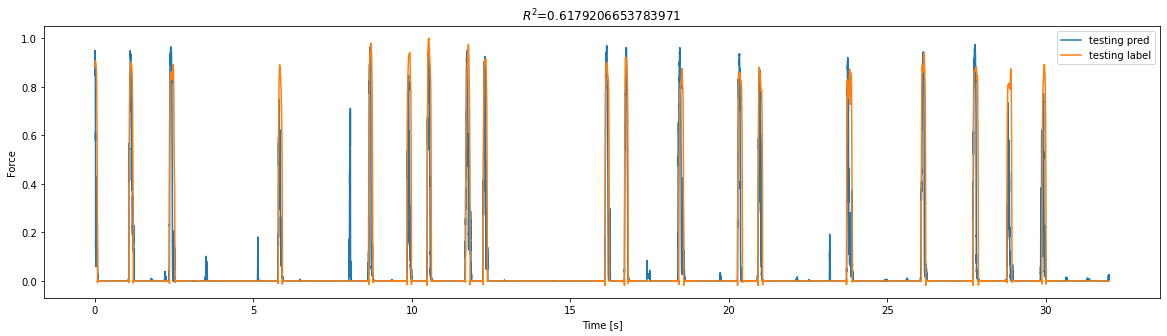

In [157]:

x_ = np.arange(0, pr_test.shape[0], 1)*0.001
plt.figure(figsize=(20,5))
plt.plot(x_, pr_test, label="testing pred")
plt.plot(x_, y_test_, label="testing label")
plt.xlabel("Time [s]")
plt.ylabel("Force")
plt.title(r"$R^2$"+"="+str(metrics.r2_score(y_test_, pr_test)))
plt.legend()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


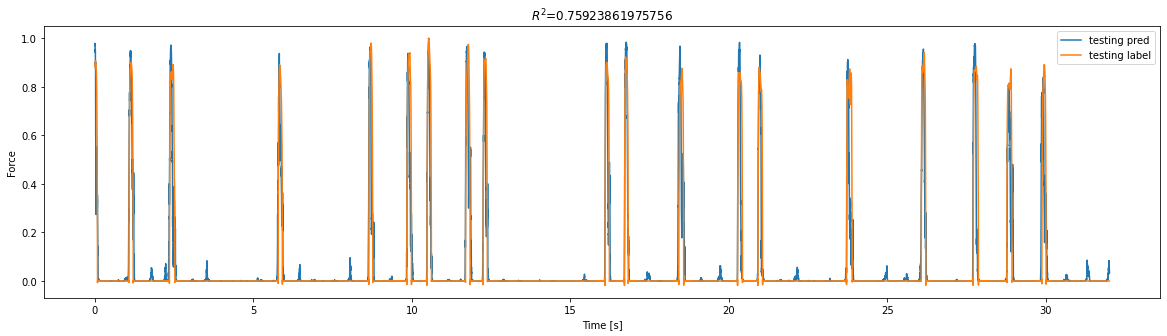

In [91]:
model = load_model('best_cnn128x2_model.h5', custom_objects={'correlation__': correlation__})

# get the test set label and predictions
gen_ = generator_regression(X_test, y_test, batch_size, \
                        samples, rebalance=False)
pr_test = model.predict(gen_, steps=int(X_test.shape[0]/batch_size))[:,0]
gen_ = generator_regression(X_test, y_test, batch_size, \
                        samples, rebalance=False)
y_test_ = get_label_from_gen(gen_, X_test, batch_size)


x_ = np.arange(0, pr_test.shape[0], 1)*0.001
plt.figure(figsize=(20,5))
plt.plot(x_, pr_test, label="testing pred")
plt.plot(x_, y_test_, label="testing label")
plt.xlabel("Time [s]")
plt.ylabel("Force")
plt.title(r"$R^2$"+"="+str(metrics.r2_score(y_test_, pr_test)))
plt.legend()

# CNN 128x4

In [158]:
cnn_128x4 = make_cnnModel(kernel_sizes=[[128,4], [128,4], [128,4]], output_units=1)
cnn_128x4.compile(Adam(), 'mse', metrics=['mae',correlation__])

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 32, 6, 128)        16416     
_________________________________________________________________
re_lu_93 (ReLU)              (None, 32, 6, 128)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 64, 6, 128)        1048640   
_________________________________________________________________
re_lu_94 (ReLU)              (None, 64, 6, 128)        0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 64, 3, 64)         0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 128, 3, 64)        4194432   
_________________________________________________________________
re_lu_95 (ReLU)              (None, 128, 3, 64)      

In [ ]:
REBALANCE_THR = 0.1

es = EarlyStopping(monitor='val_correlation__', mode='max', verbose=1, patience=5)
mc = ModelCheckpoint('best_cnn128x4_model.h5', monitor='val_correlation__', mode='max', verbose=1, save_best_only=True)

gen_tr = generator_regression(X_train, y_train, batch_size, \
                    samples, rebalance=True, rebalanced_thr=REBALANCE_THR)
gen_val = generator_regression(X_val, y_val, batch_size, \
                    samples, rebalance=True, rebalanced_thr=REBALANCE_THR)
with tf.device('/gpu:0'):
    hist = cnn_128x4.fit(gen_tr, validation_data=gen_val, steps_per_epoch=int(X_train.shape[0]/batch_size), \
                     epochs=100, validation_steps=int(X_val.shape[0]/batch_size), callbacks=[mc])
# model = load_model('best_cnn_model.h5', custom_objects={'correlation__': correlation__})

# get the training set label and predictions with rebalance = False
gen_ = generator_regression(X_train, y_train, batch_size, \
                                            samples, rebalance=False, rebalanced_thr=0.1)
pr_train = cnn_128x4.predict(gen_, steps=int(X_train.shape[0]/batch_size))[:,0]
gen_ = generator_regression(X_train, y_train, batch_size, \
                        samples, rebalance=False)
y_train_ = get_label_from_gen(gen_, X_train, batch_size)

# get the test set label and predictions
gen_ = generator_regression(X_test, y_test, batch_size, \
                        samples, rebalance=False)
pr_test = cnn_128x4.predict(gen_, steps=int(X_test.shape[0]/batch_size))[:,0]
gen_ = generator_regression(X_test, y_test, batch_size, \
                        samples, rebalance=False)
y_test_ = get_label_from_gen(gen_, X_test, batch_size)

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
11/11 [==============================] - ETA: 0s - loss: 0.1856 - mae: 0.3767 - correlation__: 0.1834 WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001A11D186288> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTO

Epoch 18/100
11/11 [==============================] - ETA: 0s - loss: 0.0536 - mae: 0.1423 - correlation__: 0.8477
Epoch 00018: val_correlation__ did not improve from 0.88071
11/11 [==============================] - 116s 11s/step - loss: 0.0536 - mae: 0.1423 - correlation__: 0.8477 - val_loss: 0.0511 - val_mae: 0.1374 - val_correlation__: 0.8177
Epoch 19/100
11/11 [==============================] - ETA: 0s - loss: 0.0440 - mae: 0.1248 - correlation__: 0.8707
Epoch 00019: val_correlation__ did not improve from 0.88071
11/11 [==============================] - 111s 10s/step - loss: 0.0440 - mae: 0.1248 - correlation__: 0.8707 - val_loss: 0.0601 - val_mae: 0.1499 - val_correlation__: 0.8277
Epoch 20/100
11/11 [==============================] - ETA: 0s - loss: 0.0418 - mae: 0.1226 - correlation__: 0.8698
Epoch 00020: val_correlation__ did not improve from 0.88071
11/11 [==============================] - 116s 11s/step - loss: 0.0418 - mae: 0.1226 - correlation__: 0.8698 - val_loss: 0.0478 - 

In [31]:
tf.keras.activations.swish()

TypeError: swish() missing 1 required positional argument: 'x'

In [33]:
np.linspace(-1,1)

array([-1.        , -0.95918367, -0.91836735, -0.87755102, -0.83673469,
       -0.79591837, -0.75510204, -0.71428571, -0.67346939, -0.63265306,
       -0.59183673, -0.55102041, -0.51020408, -0.46938776, -0.42857143,
       -0.3877551 , -0.34693878, -0.30612245, -0.26530612, -0.2244898 ,
       -0.18367347, -0.14285714, -0.10204082, -0.06122449, -0.02040816,
        0.02040816,  0.06122449,  0.10204082,  0.14285714,  0.18367347,
        0.2244898 ,  0.26530612,  0.30612245,  0.34693878,  0.3877551 ,
        0.42857143,  0.46938776,  0.51020408,  0.55102041,  0.59183673,
        0.63265306,  0.67346939,  0.71428571,  0.75510204,  0.79591837,
        0.83673469,  0.87755102,  0.91836735,  0.95918367,  1.        ])

In [42]:
a = tf.constant(np.linspace(-6,2), dtype = tf.float32)

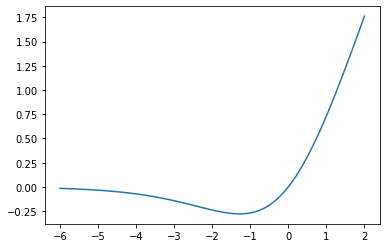

In [43]:
plt.plot(np.linspace(-6,2),tf.keras.activations.swish(a).numpy())

In [71]:
class SLU(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(SLU, self).__init__(**kwargs)
        
        
    def build(self, input_shape):
        pass
    
    def call(self, x):
        
        return tf.keras.activations.swish(x)

# CNN 64x1 with SLU

In [75]:
cnn_64x1_slu = make_cnnModel(conv_activation=SLU)
cnn_64x1_slu.compile(Adam(), loss = 'mae', metrics=['mse', correlation__])

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 32, 6, 128)        2080      
_________________________________________________________________
slu_7 (SLU)                  (None, 32, 6, 128)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 64, 6, 128)        131136    
_________________________________________________________________
slu_8 (SLU)                  (None, 64, 6, 128)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 3, 64)         0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 128, 3, 64)        524416    
_________________________________________________________________
slu_9 (SLU)                  (None, 128, 3, 64)      

In [76]:
REBALANCE_THR = 0.1

es = EarlyStopping(monitor='val_correlation__', mode='max', verbose=1, patience=5)
mc = ModelCheckpoint('best_cnn64x1_slu_model.h5', monitor='val_correlation__', mode='max', verbose=1, save_best_only=True)

gen_tr = generator_regression(X_train, y_train, batch_size, \
                    samples, rebalance=True, rebalanced_thr=REBALANCE_THR)
gen_val = generator_regression(X_val, y_val, batch_size, \
                    samples, rebalance=True, rebalanced_thr=REBALANCE_THR)
with tf.device('/gpu:0'):
    hist = cnn_64x1_slu.fit(gen_tr, validation_data=gen_val, steps_per_epoch=int(X_train.shape[0]/batch_size), \
                     epochs=100, validation_steps=int(X_val.shape[0]/batch_size), callbacks=[mc])
# model = load_model('best_cnn_model.h5', custom_objects={'correlation__': correlation__})

# get the training set label and predictions with rebalance = False
gen_ = generator_regression(X_train, y_train, batch_size, \
                                            samples, rebalance=False, rebalanced_thr=0.1)
pr_train = cnn_64x1_slu.predict(gen_, steps=int(X_train.shape[0]/batch_size))[:,0]
gen_ = generator_regression(X_train, y_train, batch_size, \
                        samples, rebalance=False)
y_train_ = get_label_from_gen(gen_, X_train, batch_size)

# get the test set label and predictions
gen_ = generator_regression(X_test, y_test, batch_size, \
                        samples, rebalance=False)
pr_test = cnn_64x1_slu.predict(gen_, steps=int(X_test.shape[0]/batch_size))[:,0]
gen_ = generator_regression(X_test, y_test, batch_size, \
                        samples, rebalance=False)
y_test_ = get_label_from_gen(gen_, X_test, batch_size)

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
11/11 [==============================] - ETA: 0s - loss: 0.3308 - mse: 0.1882 - correlation__: 0.2480WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001BA98DB4CA8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOG

Epoch 42/100
11/11 [==============================] - ETA: 0s - loss: 0.0407 - mse: 0.0077 - correlation__: 0.9758
Epoch 00042: val_correlation__ did not improve from 0.84987
11/11 [==============================] - 11s 1s/step - loss: 0.0407 - mse: 0.0077 - correlation__: 0.9758 - val_loss: 0.1320 - val_mse: 0.0632 - val_correlation__: 0.8099
Epoch 43/100
11/11 [==============================] - ETA: 0s - loss: 0.0477 - mse: 0.0119 - correlation__: 0.9644
Epoch 00043: val_correlation__ improved from 0.84987 to 0.85328, saving model to best_cnn64x1_slu_model.h5
11/11 [==============================] - 11s 1s/step - loss: 0.0477 - mse: 0.0119 - correlation__: 0.9644 - val_loss: 0.1286 - val_mse: 0.0472 - val_correlation__: 0.8533
Epoch 44/100
11/11 [==============================] - ETA: 0s - loss: 0.0447 - mse: 0.0075 - correlation__: 0.9783
Epoch 00044: val_correlation__ did not improve from 0.85328
11/11 [==============================] - 11s 1s/step - loss: 0.0447 - mse: 0.0075 - co

Epoch 66/100
11/11 [==============================] - ETA: 0s - loss: 0.0288 - mse: 0.0029 - correlation__: 0.9935
Epoch 00066: val_correlation__ did not improve from 0.85328
11/11 [==============================] - 11s 1s/step - loss: 0.0288 - mse: 0.0029 - correlation__: 0.9935 - val_loss: 0.1345 - val_mse: 0.0597 - val_correlation__: 0.8200
Epoch 67/100
11/11 [==============================] - ETA: 0s - loss: 0.0224 - mse: 0.0022 - correlation__: 0.9936
Epoch 00067: val_correlation__ did not improve from 0.85328
11/11 [==============================] - 11s 1s/step - loss: 0.0224 - mse: 0.0022 - correlation__: 0.9936 - val_loss: 0.1171 - val_mse: 0.0512 - val_correlation__: 0.8399
Epoch 68/100
11/11 [==============================] - ETA: 0s - loss: 0.0258 - mse: 0.0026 - correlation__: 0.9937
Epoch 00068: val_correlation__ did not improve from 0.85328
11/11 [==============================] - 12s 1s/step - loss: 0.0258 - mse: 0.0026 - correlation__: 0.9937 - val_loss: 0.1576 - val_ms

Epoch 90/100
11/11 [==============================] - ETA: 0s - loss: 0.0203 - mse: 0.0019 - correlation__: 0.9947
Epoch 00090: val_correlation__ did not improve from 0.85328
11/11 [==============================] - 11s 1s/step - loss: 0.0203 - mse: 0.0019 - correlation__: 0.9947 - val_loss: 0.1298 - val_mse: 0.0588 - val_correlation__: 0.8141
Epoch 91/100
11/11 [==============================] - ETA: 0s - loss: 0.0177 - mse: 0.0015 - correlation__: 0.9962
Epoch 00091: val_correlation__ did not improve from 0.85328
11/11 [==============================] - 11s 1s/step - loss: 0.0177 - mse: 0.0015 - correlation__: 0.9962 - val_loss: 0.1464 - val_mse: 0.0732 - val_correlation__: 0.7749
Epoch 92/100
11/11 [==============================] - ETA: 0s - loss: 0.0217 - mse: 0.0017 - correlation__: 0.9962
Epoch 00092: val_correlation__ did not improve from 0.85328
11/11 [==============================] - 11s 1s/step - loss: 0.0217 - mse: 0.0017 - correlation__: 0.9962 - val_loss: 0.1292 - val_ms

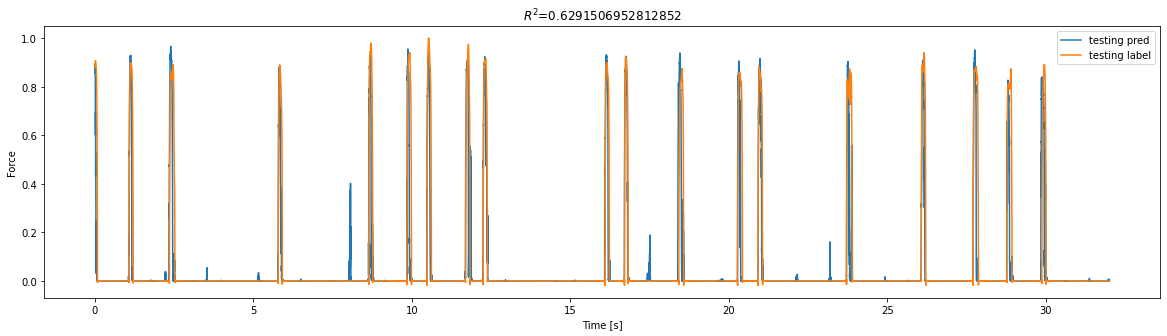

In [77]:
x_ = np.arange(0, pr_test.shape[0], 1)*0.001
plt.figure(figsize=(20,5))
plt.plot(x_, pr_test, label="testing pred")
plt.plot(x_, y_test_, label="testing label")
plt.xlabel("Time [s]")
plt.ylabel("Force")
plt.title(r"$R^2$"+"="+str(metrics.r2_score(y_test_, pr_test)))
plt.legend()

# CNN 128x2 with SLU

In [82]:
cnn_128x2_slu = make_cnnModel(conv_activation=SLU, kernel_sizes=[[128,2],[128,2],[128,2]],
                              output_units=2)
cnn_128x2_slu.compile(Adam(), loss = 'mae', metrics=['mse', correlation__])

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 32, 6, 128)        8224      
_________________________________________________________________
slu_16 (SLU)                 (None, 32, 6, 128)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 64, 6, 128)        524352    
_________________________________________________________________
slu_17 (SLU)                 (None, 64, 6, 128)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 64, 3, 64)         0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 128, 3, 64)        2097280   
_________________________________________________________________
slu_18 (SLU)                 (None, 128, 3, 64)      

Epoch 1/100
11/11 [==============================] - ETA: 0s - loss: 0.2441 - mse: 0.1607 - correlation__: 0.5264
Epoch 00001: val_correlation__ improved from -inf to 0.69910, saving model to best_cnn128x2_slu_model.h5
11/11 [==============================] - 37s 3s/step - loss: 0.2441 - mse: 0.1607 - correlation__: 0.5264 - val_loss: 0.1847 - val_mse: 0.1046 - val_correlation__: 0.6991
Epoch 2/100
11/11 [==============================] - ETA: 0s - loss: 0.2491 - mse: 0.1672 - correlation__: 0.4770
Epoch 00002: val_correlation__ improved from 0.69910 to 0.75913, saving model to best_cnn128x2_slu_model.h5
11/11 [==============================] - 37s 3s/step - loss: 0.2491 - mse: 0.1672 - correlation__: 0.4770 - val_loss: 0.1542 - val_mse: 0.0768 - val_correlation__: 0.7591
Epoch 3/100
11/11 [==============================] - ETA: 0s - loss: 0.2025 - mse: 0.1228 - correlation__: 0.6089
Epoch 00003: val_correlation__ did not improve from 0.75913
11/11 [==============================] - 37

Epoch 23/100
11/11 [==============================] - ETA: 0s - loss: 0.1204 - mse: 0.0564 - correlation__: 0.8472
Epoch 00023: val_correlation__ did not improve from 0.82744
11/11 [==============================] - 37s 3s/step - loss: 0.1204 - mse: 0.0564 - correlation__: 0.8472 - val_loss: 0.1600 - val_mse: 0.0828 - val_correlation__: 0.7447
Epoch 24/100
11/11 [==============================] - ETA: 0s - loss: 0.0922 - mse: 0.0368 - correlation__: 0.8775
Epoch 00024: val_correlation__ improved from 0.82744 to 0.84504, saving model to best_cnn128x2_slu_model.h5
11/11 [==============================] - 38s 3s/step - loss: 0.0922 - mse: 0.0368 - correlation__: 0.8775 - val_loss: 0.1197 - val_mse: 0.0463 - val_correlation__: 0.8450
Epoch 25/100
11/11 [==============================] - ETA: 0s - loss: 0.0855 - mse: 0.0316 - correlation__: 0.8908
Epoch 00025: val_correlation__ did not improve from 0.84504
11/11 [==============================] - 37s 3s/step - loss: 0.0855 - mse: 0.0316 - c

Epoch 70/100
11/11 [==============================] - ETA: 0s - loss: 0.0328 - mse: 0.0075 - correlation__: 0.9778
Epoch 00070: val_correlation__ did not improve from 0.87473
11/11 [==============================] - 37s 3s/step - loss: 0.0328 - mse: 0.0075 - correlation__: 0.9778 - val_loss: 0.1095 - val_mse: 0.0430 - val_correlation__: 0.8595
Epoch 71/100
11/11 [==============================] - ETA: 0s - loss: 0.0322 - mse: 0.0051 - correlation__: 0.9840
Epoch 00071: val_correlation__ did not improve from 0.87473
11/11 [==============================] - 37s 3s/step - loss: 0.0322 - mse: 0.0051 - correlation__: 0.9840 - val_loss: 0.1226 - val_mse: 0.0510 - val_correlation__: 0.8460
Epoch 72/100
11/11 [==============================] - ETA: 0s - loss: 0.0335 - mse: 0.0055 - correlation__: 0.9829
Epoch 00072: val_correlation__ did not improve from 0.87473
11/11 [==============================] - 38s 3s/step - loss: 0.0335 - mse: 0.0055 - correlation__: 0.9829 - val_loss: 0.1206 - val_ms

Epoch 94/100
11/11 [==============================] - ETA: 0s - loss: 0.0214 - mse: 0.0016 - correlation__: 0.9964
Epoch 00094: val_correlation__ did not improve from 0.87473
11/11 [==============================] - 38s 3s/step - loss: 0.0214 - mse: 0.0016 - correlation__: 0.9964 - val_loss: 0.1197 - val_mse: 0.0511 - val_correlation__: 0.8438
Epoch 95/100
11/11 [==============================] - ETA: 0s - loss: 0.0228 - mse: 0.0017 - correlation__: 0.9961
Epoch 00095: val_correlation__ did not improve from 0.87473
11/11 [==============================] - 37s 3s/step - loss: 0.0228 - mse: 0.0017 - correlation__: 0.9961 - val_loss: 0.1349 - val_mse: 0.0658 - val_correlation__: 0.7976
Epoch 96/100
11/11 [==============================] - ETA: 0s - loss: 0.0163 - mse: 0.0011 - correlation__: 0.9965
Epoch 00096: val_correlation__ did not improve from 0.87473
11/11 [==============================] - 37s 3s/step - loss: 0.0163 - mse: 0.0011 - correlation__: 0.9965 - val_loss: 0.1212 - val_ms

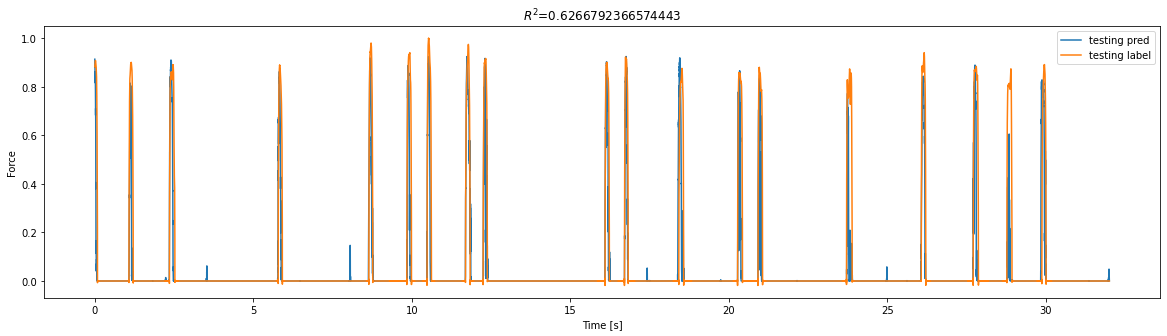

In [84]:
REBALANCE_THR = 0.1

es = EarlyStopping(monitor='val_correlation__', mode='max', verbose=1, patience=5)
mc = ModelCheckpoint('best_cnn128x2_slu_model.h5', monitor='val_correlation__', mode='max', verbose=1, save_best_only=True)

gen_tr = generator_regression(X_train, y_train, batch_size, \
                    samples, rebalance=True, rebalanced_thr=REBALANCE_THR)
gen_val = generator_regression(X_val, y_val, batch_size, \
                    samples, rebalance=True, rebalanced_thr=REBALANCE_THR)
with tf.device('/gpu:0'):
    hist = cnn_128x2_slu.fit(gen_tr, validation_data=gen_val, steps_per_epoch=int(X_train.shape[0]/batch_size), \
                     epochs=100, validation_steps=int(X_val.shape[0]/batch_size), callbacks=[mc])
# model = load_model('best_cnn_model.h5', custom_objects={'correlation__': correlation__})

# get the training set label and predictions with rebalance = False
gen_ = generator_regression(X_train, y_train, batch_size, \
                                            samples, rebalance=False, rebalanced_thr=0.1)
pr_train = cnn_128x2_slu.predict(gen_, steps=int(X_train.shape[0]/batch_size))[:,0]
gen_ = generator_regression(X_train, y_train, batch_size, \
                        samples, rebalance=False)
y_train_ = get_label_from_gen(gen_, X_train, batch_size)

# get the test set label and predictions
gen_ = generator_regression(X_test, y_test, batch_size, \
                        samples, rebalance=False)
pr_test = cnn_128x2_slu.predict(gen_, steps=int(X_test.shape[0]/batch_size))[:,0]
gen_ = generator_regression(X_test, y_test, batch_size, \
                        samples, rebalance=False)
y_test_ = get_label_from_gen(gen_, X_test, batch_size)


x_ = np.arange(0, pr_test.shape[0], 1)*0.001
plt.figure(figsize=(20,5))
plt.plot(x_, pr_test, label="testing pred")
plt.plot(x_, y_test_, label="testing label")
plt.xlabel("Time [s]")
plt.ylabel("Force")
plt.title(r"$R^2$"+"="+str(metrics.r2_score(y_test_, pr_test)))
plt.legend()

In [88]:
cnn_128x2_slu.load_weights('best_cnn128x2_slu_model.h5')

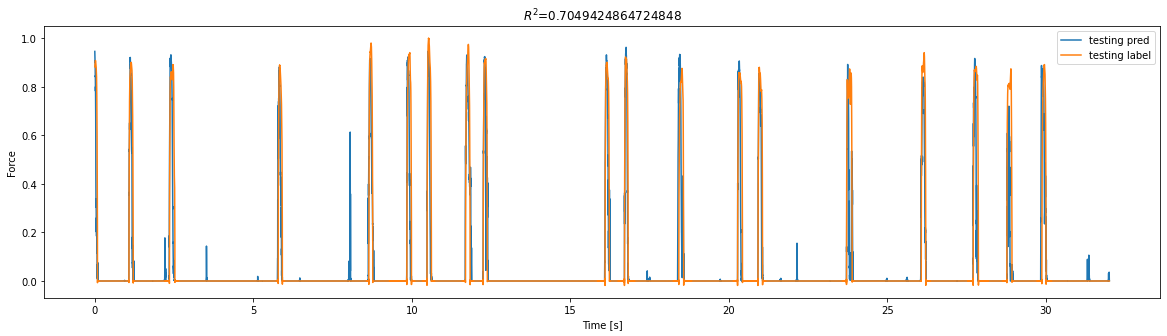

In [89]:
gen_ = generator_regression(X_test, y_test, batch_size, \
                        samples, rebalance=False)
pr_test = cnn_128x2_slu.predict(gen_, steps=int(X_test.shape[0]/batch_size))[:,0]
gen_ = generator_regression(X_test, y_test, batch_size, \
                        samples, rebalance=False)
y_test_ = get_label_from_gen(gen_, X_test, batch_size)


x_ = np.arange(0, pr_test.shape[0], 1)*0.001
plt.figure(figsize=(20,5))
plt.plot(x_, pr_test, label="testing pred")
plt.plot(x_, y_test_, label="testing label")
plt.xlabel("Time [s]")
plt.ylabel("Force")
plt.title(r"$R^2$"+"="+str(metrics.r2_score(y_test_, pr_test)))
plt.legend()

# model comparison
        

In [118]:
model_list = ['best_cnn64x1_slu_model.h5', 'best_cnn128x2_slu_model.h5',
            'best_cnn128_model.h5','best_cnn128x2_model.h5','best_cnn128x3_model.h5',
              'best_cnn_model.h5']
results = []

for m in model_list:
    print(m)
    model = load_model(m, custom_objects={'correlation__': correlation__, "SLU": SLU})
    pr_test = model.predict(gen_, steps=int(X_test.shape[0]/batch_size))[:,0]
    results.append(metrics.r2_score(y_test_, pr_test))
    
print(results)

best_cnn64x1_slu_model.h5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
best_cnn128x2_slu_model.h5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report 

In [121]:
metrics.r2_score(y_test_, pr_test)

-0.7285629191063685

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

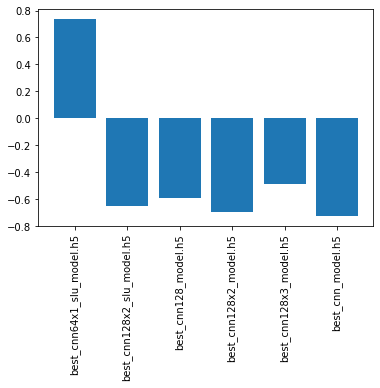

In [122]:
plt.bar(model_list,results)
plt.xticks(rotation = 90)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


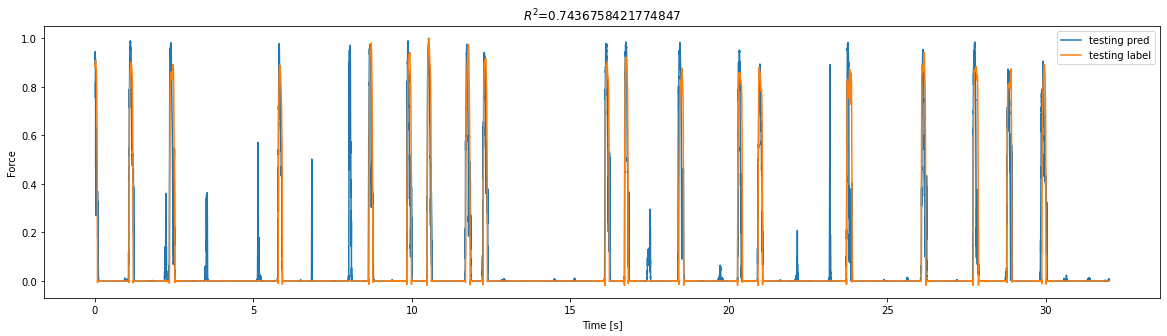

In [127]:
model = load_model('best_cnn_model.h5', custom_objects={'correlation__': correlation__, "SLU": SLU})
pr_test = model.predict(gen_, steps=int(X_test.shape[0]/batch_size))[:,0]
gen_ = generator_regression(X_test, y_test, batch_size, \
                        samples, rebalance=False)
y_test_ = get_label_from_gen(gen_, X_test, batch_size)


x_ = np.arange(0, pr_test.shape[0], 1)*0.001
plt.figure(figsize=(20,5))
plt.plot(x_, pr_test, label="testing pred")
plt.plot(x_, y_test_, label="testing label")
plt.xlabel("Time [s]")
plt.ylabel("Force")
plt.title(r"$R^2$"+"="+str(metrics.r2_score(y_test_, pr_test)))
plt.legend()

In [134]:
class NegReLU(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(NegReLU, self).__init__(**kwargs)
        
        
    def build(self, input_shape):
        pass
    
    def call(self, x):
        
        return tf.minimum(x,0)

In [135]:
l = NegReLU()

In [136]:
l.call(a)

<tf.Tensor: shape=(50,), dtype=float32, numpy=
array([-6.        , -5.836735  , -5.6734695 , -5.5102043 , -5.3469386 ,
       -5.1836734 , -5.020408  , -4.857143  , -4.6938777 , -4.5306125 ,
       -4.367347  , -4.2040815 , -4.0408163 , -3.877551  , -3.7142856 ,
       -3.5510204 , -3.3877552 , -3.2244897 , -3.0612245 , -2.8979592 ,
       -2.7346938 , -2.5714285 , -2.4081633 , -2.2448978 , -2.0816326 ,
       -1.9183674 , -1.755102  , -1.5918367 , -1.4285715 , -1.2653061 ,
       -1.1020408 , -0.93877554, -0.7755102 , -0.6122449 , -0.4489796 ,
       -0.2857143 , -0.12244898,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
      dtype=float32)>

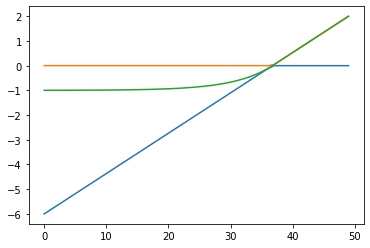

In [141]:
plt.plot(NegReLU().call(a))
plt.plot(ReLU().call(a))
plt.plot(ELU().call(a))

In [158]:
input_shape = (1,6,128)
n_conv = 2
output_n = 1

In [166]:
input_layer = Input(input_shape)

x_pos = Conv2D(32, kernel_size = [64,1], padding = 'same' )(input_layer)
for i in range(n_conv):
    x_pos = Conv2D(32, kernel_size = [64,1], padding = 'same')(x_pos)
    x_pos = ReLU()(x_pos)
    
x_neg = Conv2D(32, kernel_size = [64,1], padding = 'same' )(input_layer)
for i in range(n_conv):
    x_neg = Conv2D(32, kernel_size = [64,1], padding = 'same')(x_neg)
    x_neg = NegReLU()(x_neg)
    
concat_layer = Concatenate()([x_pos, x_neg])
dense1 = Dense(100)(concat_layer)
dense1 = SLU()(dense1)
dense1 = Flatten()(dense1)
dense2 = Dense(100)(dense1)
dense2 = SLU()(dense2)
output = Dense(output_n, activation = 'linear')(dense2)

    
model = Model(input_layer, output)
model.summary()   

model.compile(Adam(), 'mae', metrics = ['mse', correlation__])

Model: "functional_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_33 (InputLayer)           [(None, 1, 6, 128)]  0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 32, 6, 128)   2080        input_33[0][0]                   
__________________________________________________________________________________________________
conv2d_97 (Conv2D)              (None, 32, 6, 128)   2080        input_33[0][0]                   
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 32, 6, 128)   65568       conv2d_94[0][0]                  
______________________________________________________________________________________

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
11/11 [==============================] - ETA: 0s - loss: 1.4212 - mse: 9.3872 - correlation__: 0.2270 WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001BAF7F69F78> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTO

Epoch 18/100
11/11 [==============================] - ETA: 0s - loss: 0.2169 - mse: 0.0743 - correlation__: 0.8230
Epoch 00018: val_correlation__ did not improve from 0.83703
11/11 [==============================] - 15s 1s/step - loss: 0.2169 - mse: 0.0743 - correlation__: 0.8230 - val_loss: 0.2041 - val_mse: 0.0720 - val_correlation__: 0.7298
Epoch 19/100
11/11 [==============================] - ETA: 0s - loss: 0.1646 - mse: 0.0468 - correlation__: 0.8797
Epoch 00019: val_correlation__ did not improve from 0.83703
11/11 [==============================] - 15s 1s/step - loss: 0.1646 - mse: 0.0468 - correlation__: 0.8797 - val_loss: 0.1930 - val_mse: 0.0598 - val_correlation__: 0.7826
Epoch 20/100
11/11 [==============================] - ETA: 0s - loss: 0.1558 - mse: 0.0417 - correlation__: 0.8783
Epoch 00020: val_correlation__ did not improve from 0.83703
11/11 [==============================] - 15s 1s/step - loss: 0.1558 - mse: 0.0417 - correlation__: 0.8783 - val_loss: 0.1841 - val_ms

Epoch 42/100
11/11 [==============================] - ETA: 0s - loss: 0.1624 - mse: 0.0416 - correlation__: 0.9109
Epoch 00042: val_correlation__ did not improve from 0.83703
11/11 [==============================] - 15s 1s/step - loss: 0.1624 - mse: 0.0416 - correlation__: 0.9109 - val_loss: 0.1786 - val_mse: 0.0647 - val_correlation__: 0.7797
Epoch 43/100
11/11 [==============================] - ETA: 0s - loss: 0.1575 - mse: 0.0492 - correlation__: 0.8753
Epoch 00043: val_correlation__ did not improve from 0.83703
11/11 [==============================] - 15s 1s/step - loss: 0.1575 - mse: 0.0492 - correlation__: 0.8753 - val_loss: 0.2706 - val_mse: 0.1375 - val_correlation__: 0.6458
Epoch 44/100
11/11 [==============================] - ETA: 0s - loss: 0.1939 - mse: 0.0759 - correlation__: 0.7666
Epoch 00044: val_correlation__ did not improve from 0.83703
11/11 [==============================] - 15s 1s/step - loss: 0.1939 - mse: 0.0759 - correlation__: 0.7666 - val_loss: 0.1991 - val_ms

Epoch 66/100
11/11 [==============================] - ETA: 0s - loss: 0.1030 - mse: 0.0201 - correlation__: 0.9390
Epoch 00066: val_correlation__ did not improve from 0.83703
11/11 [==============================] - 15s 1s/step - loss: 0.1030 - mse: 0.0201 - correlation__: 0.9390 - val_loss: 0.2119 - val_mse: 0.0888 - val_correlation__: 0.7578
Epoch 67/100
11/11 [==============================] - ETA: 0s - loss: 0.1090 - mse: 0.0240 - correlation__: 0.9326
Epoch 00067: val_correlation__ did not improve from 0.83703
11/11 [==============================] - 15s 1s/step - loss: 0.1090 - mse: 0.0240 - correlation__: 0.9326 - val_loss: 0.1649 - val_mse: 0.0565 - val_correlation__: 0.8068
Epoch 68/100
11/11 [==============================] - ETA: 0s - loss: 0.0994 - mse: 0.0209 - correlation__: 0.9318
Epoch 00068: val_correlation__ did not improve from 0.83703
11/11 [==============================] - 15s 1s/step - loss: 0.0994 - mse: 0.0209 - correlation__: 0.9318 - val_loss: 0.1619 - val_ms

Epoch 90/100
11/11 [==============================] - ETA: 0s - loss: 0.1287 - mse: 0.0288 - correlation__: 0.9239
Epoch 00090: val_correlation__ did not improve from 0.83703
11/11 [==============================] - 15s 1s/step - loss: 0.1287 - mse: 0.0288 - correlation__: 0.9239 - val_loss: 0.1881 - val_mse: 0.0707 - val_correlation__: 0.8281
Epoch 91/100
11/11 [==============================] - ETA: 0s - loss: 0.1147 - mse: 0.0268 - correlation__: 0.9242
Epoch 00091: val_correlation__ did not improve from 0.83703
11/11 [==============================] - 15s 1s/step - loss: 0.1147 - mse: 0.0268 - correlation__: 0.9242 - val_loss: 0.1500 - val_mse: 0.0525 - val_correlation__: 0.8351
Epoch 92/100
11/11 [==============================] - ETA: 0s - loss: 0.1002 - mse: 0.0226 - correlation__: 0.9341
Epoch 00092: val_correlation__ did not improve from 0.83703
11/11 [==============================] - 15s 1s/step - loss: 0.1002 - mse: 0.0226 - correlation__: 0.9341 - val_loss: 0.1665 - val_ms

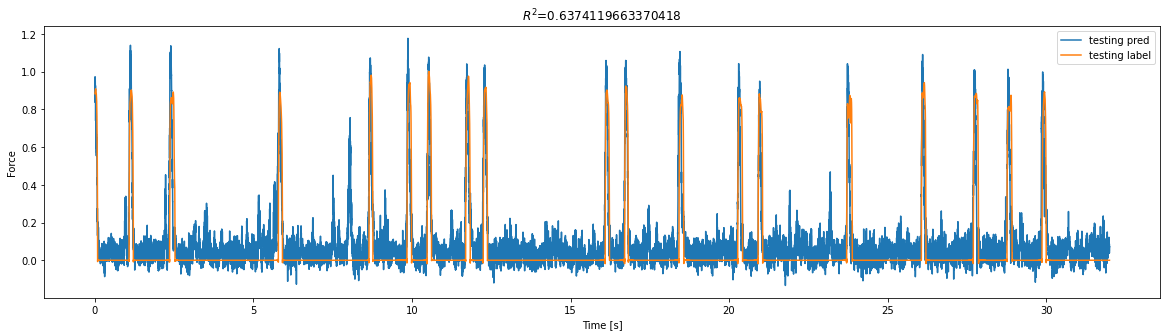

In [167]:
REBALANCE_THR = 0.1

es = EarlyStopping(monitor='val_correlation__', mode='max', verbose=1, patience=5)
mc = ModelCheckpoint('best_cnn_NegPos_model.h5', monitor='val_correlation__', mode='max', verbose=1, save_best_only=True)

gen_tr = generator_regression(X_train, y_train, batch_size, \
                    samples, rebalance=True, rebalanced_thr=REBALANCE_THR)
gen_val = generator_regression(X_val, y_val, batch_size, \
                    samples, rebalance=True, rebalanced_thr=REBALANCE_THR)
with tf.device('/gpu:0'):
    hist = model.fit(gen_tr, validation_data=gen_val, steps_per_epoch=int(X_train.shape[0]/batch_size), \
                     epochs=100, validation_steps=int(X_val.shape[0]/batch_size), callbacks=[mc])
# model = load_model('best_cnn_model.h5', custom_objects={'correlation__': correlation__})

# get the training set label and predictions with rebalance = False
gen_ = generator_regression(X_train, y_train, batch_size, \
                                            samples, rebalance=False, rebalanced_thr=0.1)
pr_train = model.predict(gen_, steps=int(X_train.shape[0]/batch_size))[:,0]
gen_ = generator_regression(X_train, y_train, batch_size, \
                        samples, rebalance=False)
y_train_ = get_label_from_gen(gen_, X_train, batch_size)

# get the test set label and predictions
gen_ = generator_regression(X_test, y_test, batch_size, \
                        samples, rebalance=False)
pr_test = model.predict(gen_, steps=int(X_test.shape[0]/batch_size))[:,0]
gen_ = generator_regression(X_test, y_test, batch_size, \
                        samples, rebalance=False)
y_test_ = get_label_from_gen(gen_, X_test, batch_size)


x_ = np.arange(0, pr_test.shape[0], 1)*0.001
plt.figure(figsize=(20,5))
plt.plot(x_, pr_test, label="testing pred")
plt.plot(x_, y_test_, label="testing label")
plt.xlabel("Time [s]")
plt.ylabel("Force")
plt.title(r"$R^2$"+"="+str(metrics.r2_score(y_test_, pr_test)))
plt.legend()

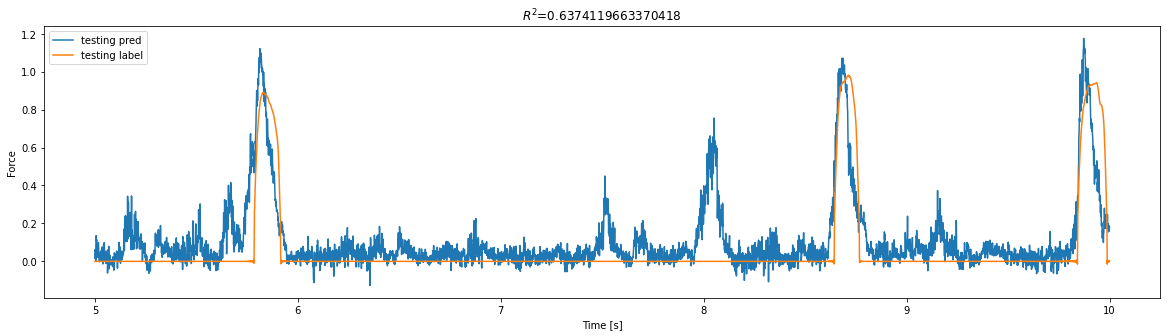

In [168]:
x_ = np.arange(0, pr_test.shape[0], 1)*0.001
plt.figure(figsize=(20,5))
plt.plot(x_[5000:10000], pr_test[5000:10000], label="testing pred")
plt.plot(x_[5000:10000], y_test_[5000:10000], label="testing label")
plt.xlabel("Time [s]")
plt.ylabel("Force")
plt.title(r"$R^2$"+"="+str(metrics.r2_score(y_test_, pr_test)))
plt.legend()

# CNN 64x1 with BN

In [6]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [10]:
cnn_64x1bn = make_cnnModel(batch_norm= True)
cnn_64x1bn.compile(Adam(), 'mae', metrics= [correlation__])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 6, 128)        2080      
_________________________________________________________________
re_lu (ReLU)                 (None, 32, 6, 128)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 6, 128)        512       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 6, 128)        131136    
_________________________________________________________________
re_lu_1 (ReLU)               (None, 64, 6, 128)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 6, 128)        512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 3, 64)         0

In [ ]:
REBALANCE_THR = 0.1

es = EarlyStopping(monitor='val_correlation__', mode='max', verbose=1, patience=5)
mc = ModelCheckpoint('best_cnn_64x1bn_model.h5', monitor='val_correlation__', mode='max', verbose=1, save_best_only=True)

gen_tr = generator_regression(X_train, y_train, batch_size, \
                    samples, rebalance=True, rebalanced_thr=REBALANCE_THR)
gen_val = generator_regression(X_val, y_val, batch_size, \
                    samples, rebalance=True, rebalanced_thr=REBALANCE_THR)
with tf.device('/gpu:0'):
    hist = cnn_64x1bn.fit(gen_tr, validation_data=gen_val, steps_per_epoch=int(X_train.shape[0]/batch_size), \
                     epochs=100, validation_steps=int(X_val.shape[0]/batch_size))
# model = load_model('best_cnn_model.h5', custom_objects={'correlation__': correlation__})

# get the training set label and predictions with rebalance = False
gen_ = generator_regression(X_train, y_train, batch_size, \
                                            samples, rebalance=False, rebalanced_thr=0.1)
pr_train = cnn_64x1bn.predict(gen_, steps=int(X_train.shape[0]/batch_size))[:,0]
gen_ = generator_regression(X_train, y_train, batch_size, \
                        samples, rebalance=False)
y_train_ = get_label_from_gen(gen_, X_train, batch_size)

# get the test set label and predictions
gen_ = generator_regression(X_test, y_test, batch_size, \
                        samples, rebalance=False)
pr_test = cnn_64x1bn.predict(gen_, steps=int(X_test.shape[0]/batch_size))[:,0]
gen_ = generator_regression(X_test, y_test, batch_size, \
                        samples, rebalance=False)
y_test_ = get_label_from_gen(gen_, X_test, batch_size)


x_ = np.arange(0, pr_test.shape[0], 1)*0.001
plt.figure(figsize=(20,5))
plt.plot(x_, pr_test, label="testing pred")
plt.plot(x_, y_test_, label="testing label")
plt.xlabel("Time [s]")
plt.ylabel("Force")
plt.title(r"$R^2$"+"="+str(metrics.r2_score(y_test_, pr_test)))
plt.legend()

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing 

In [19]:
import keras
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

AttributeError: module 'keras.backend' has no attribute 'tensorflow_backend'

In [ ]:
keras.backend.set

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


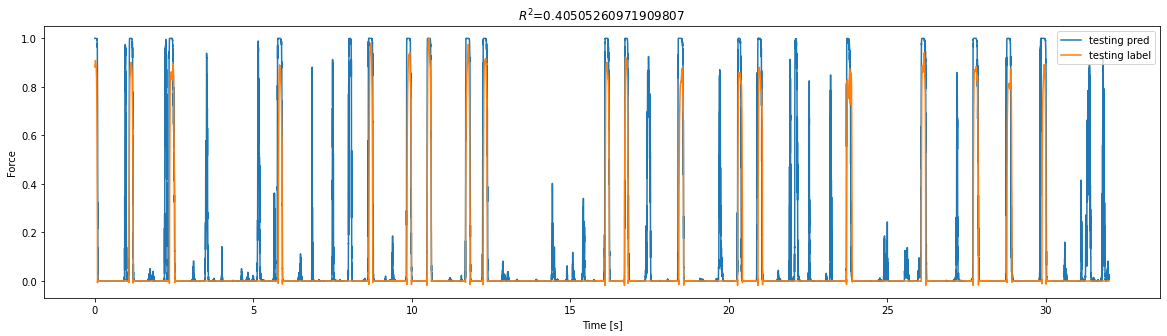

In [14]:

# get the test set label and predictions
model = load_model('best_cnn_64x1bn_model.h5', custom_objects={"correlation__":correlation__})

pr_test = model.predict(gen_, steps=int(X_test.shape[0]/batch_size))[:,0]
gen_ = generator_regression(X_test, y_test, batch_size, \
                        samples, rebalance=False)
y_test_ = get_label_from_gen(gen_, X_test, batch_size)


x_ = np.arange(0, pr_test.shape[0], 1)*0.001
plt.figure(figsize=(20,5))
plt.plot(x_, pr_test, label="testing pred")
plt.plot(x_, y_test_, label="testing label")
plt.xlabel("Time [s]")
plt.ylabel("Force")
plt.title(r"$R^2$"+"="+str(metrics.r2_score(y_test_, pr_test)))
plt.legend()

In [32]:
cnn_1x64 = make_cnnModel(kernel_sizes= [[2,64], [2,64], [2,64]] , output_units=1)
cnn_1x64.compile(Adam(),'mae', metrics=[correlation__] )

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 32, 6, 128)        4128      
_________________________________________________________________
re_lu_50 (ReLU)              (None, 32, 6, 128)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 64, 6, 128)        262208    
_________________________________________________________________
re_lu_51 (ReLU)              (None, 64, 6, 128)        0         
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 64, 3, 64)         0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 128, 3, 64)        1048704   
_________________________________________________________________
re_lu_52 (ReLU)              (None, 128, 3, 64)      

In [33]:
REBALANCE_THR = 0.1

es = EarlyStopping(monitor='val_correlation__', mode='max', verbose=1, patience=5)
mc = ModelCheckpoint('best_cnn_1x64_model.h5', monitor='val_correlation__', mode='max', verbose=1, save_best_only=True)

gen_tr = generator_regression(X_train, y_train, batch_size, \
                    samples, rebalance=True, rebalanced_thr=REBALANCE_THR)
gen_val = generator_regression(X_val, y_val, batch_size, \
                    samples, rebalance=True, rebalanced_thr=REBALANCE_THR)
with tf.device('/gpu:0'):
    hist = cnn_1x64.fit(gen_tr, validation_data=gen_val, steps_per_epoch=int(X_train.shape[0]/batch_size), \
                     epochs=10, validation_steps=int(X_val.shape[0]/batch_size), callbacks=[mc])
# model = load_model('best_cnn_model.h5', custom_objects={'correlation__': correlation__})

# get the training set label and predictions with rebalance = False
gen_ = generator_regression(X_train, y_train, batch_size, \
                                            samples, rebalance=False, rebalanced_thr=0.1)
pr_train = cnn_1x64.predict(gen_, steps=int(X_train.shape[0]/batch_size))[:,0]
gen_ = generator_regression(X_train, y_train, batch_size, \
                        samples, rebalance=False)
y_train_ = get_label_from_gen(gen_, X_train, batch_size)

# get the test set label and predictions
gen_ = generator_regression(X_test, y_test, batch_size, \
                        samples, rebalance=False)
pr_test = cnn_1x64.predict(gen_, steps=int(X_test.shape[0]/batch_size))[:,0]
gen_ = generator_regression(X_test, y_test, batch_size, \
                        samples, rebalance=False)
y_test_ = get_label_from_gen(gen_, X_test, batch_size)


x_ = np.arange(0, pr_test.shape[0], 1)*0.001
plt.figure(figsize=(20,5))
plt.plot(x_, pr_test, label="testing pred")
plt.plot(x_, y_test_, label="testing label")
plt.xlabel("Time [s]")
plt.ylabel("Force")
plt.title(r"$R^2$"+"="+str(metrics.r2_score(y_test_, pr_test)))
plt.legend()

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
11/11 [==============================] - ETA: 0s - loss: 0.3818 - correlation__: nanWARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000025D8ACF09D8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`

KeyboardInterrupt: 

# CNN without max pooling

In [112]:
model = Sequential([
    Input((1,6,128)),
    Conv2D(32, kernel_size = [1,64], padding = 'same'),
    ELU(),
    Conv2D(32, kernel_size = [1,64], padding = 'same'),
    ELU(),
    MaxPool2D(pool_size = [1,2]),
    Conv2D(64, kernel_size = [1,16], padding = 'same'),
    ELU(),
    Conv2D(64, kernel_size = [1,16], padding = 'same'),
    ELU(),
    MaxPool2D(pool_size = [1,2]),
    DepthwiseConv2D( kernel_size = [2,18], padding = 'same'),
    ELU(),
    DepthwiseConv2D( kernel_size = [2,18], padding = 'same'),
    ELU(),
    AveragePooling2D(),
    Flatten(),
    Dense(200),
    ELU(),
    Dense(1, activation = 'linear')

    
])


model.summary()

model.compile(Adam(), 'mae', metrics=[correlation__])

Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_311 (Conv2D)          (None, 32, 6, 128)        2080      
_________________________________________________________________
elu_287 (ELU)                (None, 32, 6, 128)        0         
_________________________________________________________________
conv2d_312 (Conv2D)          (None, 32, 6, 128)        65568     
_________________________________________________________________
elu_288 (ELU)                (None, 32, 6, 128)        0         
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 32, 6, 64)         0         
_________________________________________________________________
conv2d_313 (Conv2D)          (None, 64, 6, 64)         32832     
_________________________________________________________________
elu_289 (ELU)                (None, 64, 6, 64)       

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
11/11 [==============================] - ETA: 0s - loss: 0.3630 - correlation__: 0.3871WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000025DBF5C1438> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY

Epoch 21/100
11/11 [==============================] - ETA: 0s - loss: 0.2006 - correlation__: 0.8079
Epoch 00021: val_correlation__ did not improve from 0.86314
11/11 [==============================] - 5s 481ms/step - loss: 0.2006 - correlation__: 0.8079 - val_loss: 0.2037 - val_correlation__: 0.8429
Epoch 22/100
11/11 [==============================] - ETA: 0s - loss: 0.1847 - correlation__: 0.8306
Epoch 00022: val_correlation__ did not improve from 0.86314
11/11 [==============================] - 5s 477ms/step - loss: 0.1847 - correlation__: 0.8306 - val_loss: 0.1725 - val_correlation__: 0.8419
Epoch 23/100
11/11 [==============================] - ETA: 0s - loss: 0.1602 - correlation__: 0.8388
Epoch 00023: val_correlation__ did not improve from 0.86314
11/11 [==============================] - 5s 479ms/step - loss: 0.1602 - correlation__: 0.8388 - val_loss: 0.1547 - val_correlation__: 0.8394
Epoch 24/100
11/11 [==============================] - ETA: 0s - loss: 0.1603 - correlation__: 

Epoch 48/100
11/11 [==============================] - ETA: 0s - loss: 0.1067 - correlation__: 0.9170
Epoch 00048: val_correlation__ did not improve from 0.87934
11/11 [==============================] - 5s 480ms/step - loss: 0.1067 - correlation__: 0.9170 - val_loss: 0.1224 - val_correlation__: 0.8791
Epoch 49/100
11/11 [==============================] - ETA: 0s - loss: 0.0958 - correlation__: 0.9295
Epoch 00049: val_correlation__ did not improve from 0.87934
11/11 [==============================] - 5s 476ms/step - loss: 0.0958 - correlation__: 0.9295 - val_loss: 0.1363 - val_correlation__: 0.8577
Epoch 50/100
11/11 [==============================] - ETA: 0s - loss: 0.1398 - correlation__: 0.9006
Epoch 00050: val_correlation__ did not improve from 0.87934
11/11 [==============================] - 5s 479ms/step - loss: 0.1398 - correlation__: 0.9006 - val_loss: 0.2489 - val_correlation__: 0.7390
Epoch 51/100
11/11 [==============================] - ETA: 0s - loss: 0.1481 - correlation__: 

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


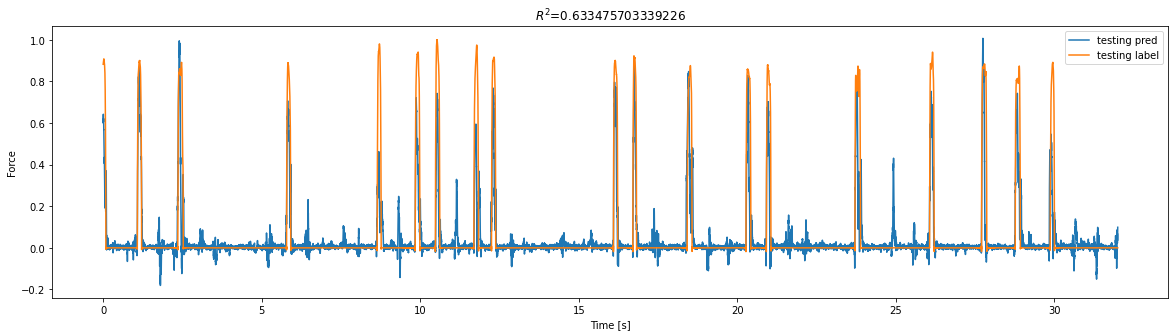

In [113]:
REBALANCE_THR = 0.1

es = EarlyStopping(monitor='val_correlation__', mode='max', verbose=1, patience=5)
mc = ModelCheckpoint('best_cnn_1x64_model.h5', monitor='val_correlation__', mode='max', verbose=1, save_best_only=True)

gen_tr = generator_regression(X_train, y_train, batch_size, \
                    samples, rebalance=True, rebalanced_thr=REBALANCE_THR)
gen_val = generator_regression(X_val, y_val, batch_size, \
                    samples, rebalance=True, rebalanced_thr=REBALANCE_THR)
with tf.device('/gpu:0'):
    hist = model.fit(gen_tr, validation_data=gen_val, steps_per_epoch=int(X_train.shape[0]/batch_size), \
                     epochs=100, validation_steps=int(X_val.shape[0]/batch_size), callbacks=[mc])
# model = load_model('best_cnn_model.h5', custom_objects={'correlation__': correlation__})


# get the test set label and predictions
gen_ = generator_regression(X_test, y_test, batch_size, \
                        samples, rebalance=False)
pr_test = model.predict(gen_, steps=int(X_test.shape[0]/batch_size))[:,0]
gen_ = generator_regression(X_test, y_test, batch_size, \
                        samples, rebalance=False)
y_test_ = get_label_from_gen(gen_, X_test, batch_size)


x_ = np.arange(0, pr_test.shape[0], 1)*0.001
plt.figure(figsize=(20,5))
plt.plot(x_, pr_test, label="testing pred")
plt.plot(x_, y_test_, label="testing label")
plt.xlabel("Time [s]")
plt.ylabel("Force")
plt.title(r"$R^2$"+"="+str(metrics.r2_score(y_test_, pr_test)))
plt.legend()

In [115]:
model.load_weights('best_cnn_1x64_model.h5')

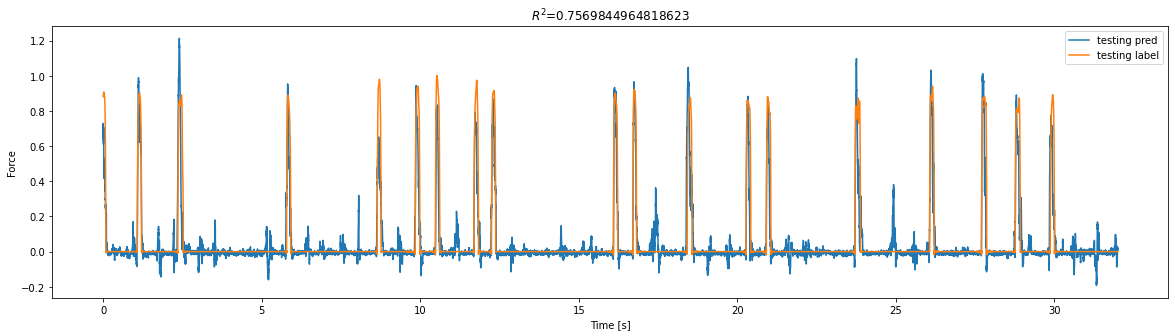

In [117]:
pr_test = model.predict(gen_, steps=int(X_test.shape[0]/batch_size))[:,0]
gen_ = generator_regression(X_test, y_test, batch_size, \
                        samples, rebalance=False)
y_test_ = get_label_from_gen(gen_, X_test, batch_size)


x_ = np.arange(0, pr_test.shape[0], 1)*0.001
plt.figure(figsize=(20,5))
plt.plot(x_, pr_test, label="testing pred")
plt.plot(x_, y_test_, label="testing label")
plt.xlabel("Time [s]")
plt.ylabel("Force")
plt.title(r"$R^2$"+"="+str(metrics.r2_score(y_test_, pr_test)))
plt.legend()

# Increasing the epoch size

In [11]:
model2 = Sequential([
    Input((1,6,256)),
    Conv2D(32, kernel_size = [1,64], padding = 'same'),
    ELU(),
    Conv2D(32, kernel_size = [1,64], padding = 'same'),
    ELU(),
    MaxPool2D(pool_size = [1,2]),
    Conv2D(32, kernel_size = [1,16], padding = 'same'),
    ELU(),
    Conv2D(32, kernel_size = [1,16], padding = 'same'),
    ELU(),
    MaxPool2D(pool_size = [1,2]),
    Conv2D(32, kernel_size = [1,16], padding = 'same'),
    ELU(),
    Conv2D(32, kernel_size = [1,16], padding = 'same'),
    ELU(),
    MaxPool2D(pool_size = [1,2]),
    DepthwiseConv2D( kernel_size = [2,18], padding = 'same'),
    ELU(),
    DepthwiseConv2D( kernel_size = [2,18], padding = 'same'),
    ELU(),
    AveragePooling2D(),
    Flatten(),
    Dense(200),
    ELU(),
    Dense(1, activation = 'linear')

    
])


model2.summary()

model2.compile(Adam(), 'mae', metrics=[correlation__])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 32, 6, 256)        2080      
_________________________________________________________________
elu_20 (ELU)                 (None, 32, 6, 256)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 6, 256)        65568     
_________________________________________________________________
elu_21 (ELU)                 (None, 32, 6, 256)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 6, 128)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 32, 6, 128)        16416     
_________________________________________________________________
elu_22 (ELU)                 (None, 32, 6, 128)       

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
11/11 [==============================] - ETA: 0s - loss: 0.4731 - correlation__: 0.1541WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001AA49A5D8B8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY

Epoch 21/100
11/11 [==============================] - ETA: 0s - loss: 0.1151 - correlation__: 0.9305
Epoch 00021: val_correlation__ improved from 0.88920 to 0.89228, saving model to best_cnn_1x64_model.h5
11/11 [==============================] - 11s 1s/step - loss: 0.1151 - correlation__: 0.9305 - val_loss: 0.1338 - val_correlation__: 0.8923
Epoch 22/100
11/11 [==============================] - ETA: 0s - loss: 0.1138 - correlation__: 0.9210
Epoch 00022: val_correlation__ did not improve from 0.89228
11/11 [==============================] - 11s 997ms/step - loss: 0.1138 - correlation__: 0.9210 - val_loss: 0.1572 - val_correlation__: 0.8470
Epoch 23/100
11/11 [==============================] - ETA: 0s - loss: 0.1486 - correlation__: 0.8800
Epoch 00023: val_correlation__ did not improve from 0.89228
11/11 [==============================] - 11s 997ms/step - loss: 0.1486 - correlation__: 0.8800 - val_loss: 0.1766 - val_correlation__: 0.8615
Epoch 24/100
11/11 [==============================

Epoch 48/100
11/11 [==============================] - ETA: 0s - loss: 0.1364 - correlation__: 0.8604
Epoch 00048: val_correlation__ did not improve from 0.89568
11/11 [==============================] - 11s 997ms/step - loss: 0.1364 - correlation__: 0.8604 - val_loss: 0.1348 - val_correlation__: 0.8622
Epoch 49/100
11/11 [==============================] - ETA: 0s - loss: 0.1320 - correlation__: 0.9038
Epoch 00049: val_correlation__ did not improve from 0.89568
11/11 [==============================] - 11s 996ms/step - loss: 0.1320 - correlation__: 0.9038 - val_loss: 0.1398 - val_correlation__: 0.8597
Epoch 50/100
11/11 [==============================] - ETA: 0s - loss: 0.1028 - correlation__: 0.9290
Epoch 00050: val_correlation__ did not improve from 0.89568
11/11 [==============================] - 11s 996ms/step - loss: 0.1028 - correlation__: 0.9290 - val_loss: 0.1459 - val_correlation__: 0.8372
Epoch 51/100
11/11 [==============================] - ETA: 0s - loss: 0.1139 - correlation_

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ValueError: x and y must have same first dimension, but have shapes (16000,) and (32000,)

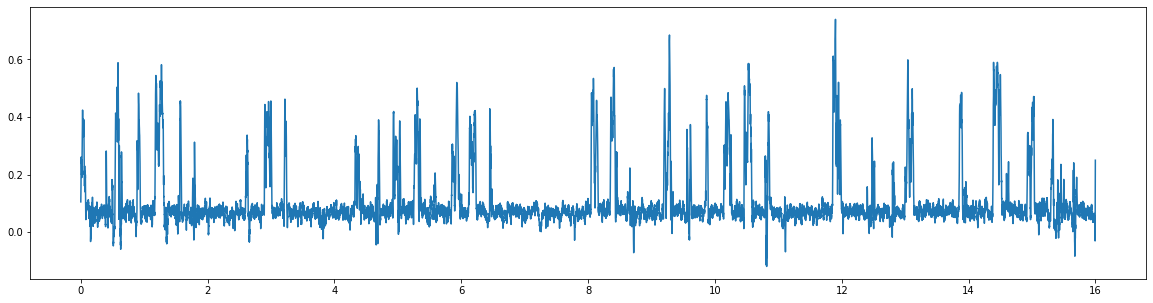

In [12]:
REBALANCE_THR = 0.1

es = EarlyStopping(monitor='val_correlation__', mode='max', verbose=1, patience=5)
mc = ModelCheckpoint('best_cnn_1x64_model.h5', monitor='val_correlation__', mode='max', verbose=1, save_best_only=True)

gen_tr = generator_regression(X_train, y_train, batch_size, \
                    256, rebalance=True, rebalanced_thr=REBALANCE_THR)
gen_val = generator_regression(X_val, y_val, batch_size, \
                    256, rebalance=True, rebalanced_thr=REBALANCE_THR)
with tf.device('/gpu:0'):
    hist = model2.fit(gen_tr, validation_data=gen_val, steps_per_epoch=int(X_train.shape[0]/batch_size), \
                     epochs=100, validation_steps=int(X_val.shape[0]/batch_size), callbacks=[mc])
# model = load_model('best_cnn_model.h5', custom_objects={'correlation__': correlation__})


# get the test set label and predictions
gen_ = generator_regression(X_test, y_test, batch_size, \
                        256, rebalance=False)
pr_test = model2.predict(gen_, steps=int(X_test.shape[0]/batch_size))[:,0]
gen_ = generator_regression(X_test, y_test, batch_size, \
                        256, rebalance=False)
y_test_ = get_label_from_gen(gen_, X_test, batch_size)


x_ = np.arange(0, pr_test.shape[0], 1)*0.001
plt.figure(figsize=(20,5))
plt.plot(x_, pr_test, label="testing pred")
plt.plot(x_, y_test_, label="testing label")
plt.xlabel("Time [s]")
plt.ylabel("Force")
plt.title(r"$R^2$"+"="+str(metrics.r2_score(y_test_, pr_test)))
plt.legend()

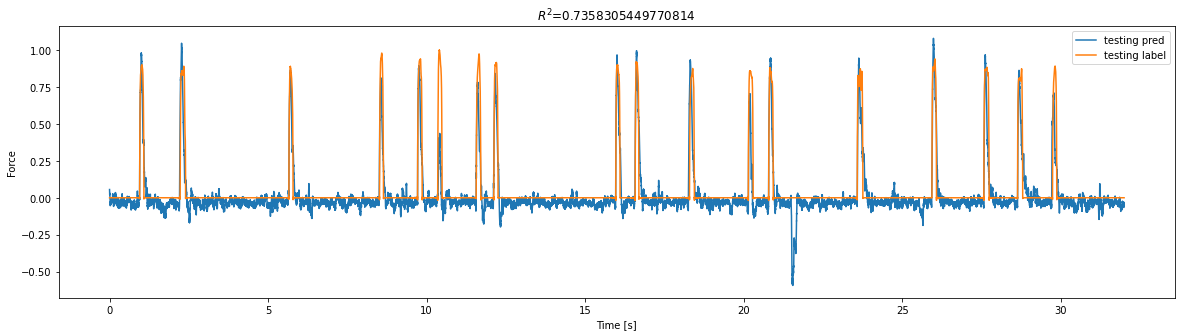

In [18]:

# get the test set label and predictions
gen_ = generator_regression(X_test, y_test, batch_size, \
                        256, rebalance=False)
pr_test = model2.predict(gen_, steps=int(X_test.shape[0]/batch_size))[:,0]
gen_ = generator_regression(X_test, y_test, batch_size, \
                        256, rebalance=False)
y_test_ = get_label_from_gen(gen_, X_test, batch_size)


x_ = np.arange(0, pr_test.shape[0], 1)*0.001
plt.figure(figsize=(20,5))
plt.plot(x_, pr_test, label="testing pred")
plt.plot(x_, y_test_, label="testing label")
plt.xlabel("Time [s]")
plt.ylabel("Force")
plt.title(r"$R^2$"+"="+str(metrics.r2_score(y_test_, pr_test)))
plt.legend()

# Grad-CAM

In [24]:
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2
class GradCAM:
	def __init__(self, model, classIdx, layerName=None):
		# store the model, the class index used to measure the class
		# activation map, and the layer to be used when visualizing
		# the class activation map
		self.model = model
		self.classIdx = classIdx
		self.layerName = layerName
		# if the layer name is None, attempt to automatically find
		# the target output layer
		if self.layerName is None:
			self.layerName = self.find_target_layer()
            
	def find_target_layer(self):
		# attempt to find the final convolutional layer in the network
		# by looping over the layers of the network in reverse order
		for layer in reversed(self.model.layers):
			# check to see if the layer has a 4D output
			if len(layer.output_shape) == 4:
				return layer.name
		# otherwise, we could not find a 4D layer so the GradCAM
		# algorithm cannot be applied
		raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")
        
	def compute_heatmap(self, image, eps=1e-8):
		# construct our gradient model by supplying (1) the inputs
		# to our pre-trained model, (2) the output of the (presumably)
		# final 4D layer in the network, and (3) the output of the
		# softmax activations from the model
		gradModel = Model(
			inputs=[self.model.inputs],
			outputs=[self.model.get_layer(self.layerName).output,
				self.model.output])
        
        
		# record operations for automatic differentiation
		with tf.GradientTape() as tape:
			# cast the image tensor to a float-32 data type, pass the
			# image through the gradient model, and grab the loss
			# associated with the specific class index
			inputs = tf.cast(image, tf.float32)
			(convOutputs, predictions) = gradModel(inputs)
			print(convOutputs.shape, predictions.shape)
			print(convOutputs[0:100])
#			loss = predictions[:, self.classIdx]
			loss = predictions[predictions>0]
		# use automatic differentiation to compute the gradients
		grads = tape.gradient(loss, convOutputs)
        
		# compute the guided gradients
		castConvOutputs = tf.cast(convOutputs > 0, "float32")
		castGrads = tf.cast(grads > 0, "float32")
		guidedGrads = castConvOutputs * castGrads * grads
		# the convolution and guided gradients have a batch dimension
		# (which we don't need) so let's grab the volume itself and
		# discard the batch
		convOutputs = convOutputs[0]
		guidedGrads = guidedGrads[0]
        
        
		# compute the average of the gradient values, and using them
		# as weights, compute the ponderation of the filters with
		# respect to the weights
		weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
		cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
        
        
		# grab the spatial dimensions of the input image and resize
		# the output class activation map to match the input image
		# dimensions
		(w, h) = (image.shape[2], image.shape[1])
		heatmap = cv2.resize(cam.numpy(), (w, h))
		# normalize the heatmap such that all values lie in the range
		# [0, 1], scale the resulting values to the range [0, 255],
		# and then convert to an unsigned 8-bit integer
		numer = heatmap - np.min(heatmap)
		denom = (heatmap.max() - heatmap.min()) + eps
		heatmap = numer / denom
		heatmap = (heatmap * 255).astype("uint8")
		# return the resulting heatmap to the calling function
		return heatmap
    
    
	def overlay_heatmap(self, heatmap, image, alpha=0.5,
		colormap=cv2.COLORMAP_VIRIDIS):
		# apply the supplied color map to the heatmap and then
		# overlay the heatmap on the input image
		heatmap = cv2.applyColorMap(heatmap, colormap)
		output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
		# return a 2-tuple of the color mapped heatmap and the output,
		# overlaid image
		return (heatmap, output)
            
            